# 01. Correlation Between Histone PTM and Metabolite Levels
**Author:** Scott Campit

## Summary
This notebook visualizes the correlation between histone post-transtional modifications and metabolite levels from the Cancer Cell Line Encyclopedia. The correlation analysis is necessary to gain a deep understanding of the data set we are modeling with machine learning.

## 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'arial'})
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator
import seaborn as sns

c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\Scott\Envs\train_lasso\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

## 2. Load the data
The data comes from the Cancer Cell Line Encyclopedia (Barretina et al., 2012). 

We'll specifically be looking at the Global Chromatin Profile dataset (Jaffe et al., 2013) and the metabolomics dataset (Li et al., 2019).

**Google sheet description:**

| Sheet name          | Description                   |
| ------------------- | ----------------------------- |
| metadata            | Meta data for the CCLE        |
| GCP_All             | All global chromatin profiles |
| GCP_Single          | Single Lysine modifications   |
| Metabolomics_All    | All metabolite profiles       |
| Metabolomics_Fat    | Fatty acids                   |
| Metabolomics_NonFat | All other metabolites         |

**References:**
  1. Barretina, J., Caponigro, G., Stransky, N., Venkatesan, K., Margolin, A. A., Kim, S., Wilson, C. J., Lehár, J., Kryukov, G. V., Sonkin, D., Reddy, A., Liu, M., Murray, L., Berger, M. F., Monahan, J. E., Morais, P., Meltzer, J., Korejwa, A., Jané-Valbuena, J., … Garraway, L. A. (2012). The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity. Nature, 483(7391), 603–607.

  2. Jaffe, J. D., Wang, Y., Chan, H. M., Zhang, J., Huether, R., Kryukov, G. V., Bhang, H.-E. C., Taylor, J. E., Hu, M., Englund, N. P., Yan, F., Wang, Z., Robert McDonald, E., 3rd, Wei, L., Ma, J., Easton, J., Yu, Z., deBeaumount, R., Gibaja, V., … Stegmeier, F. (2013). Global chromatin profiling reveals NSD2 mutations in pediatric acute lymphoblastic leukemia. Nature Genetics, 45(11), 1386–1391.

  3. Li, H., Ning, S., Ghandi, M., Kryukov, G. V., Gopal, S., Deik, A., Souza, A., Pierce, K., Keskula, P., Hernandez, D., Ann, J., Shkoza, D., Apfel, V., Zou, Y., Vazquez, F., Barretina, J., Pagliarini, R. A., Galli, G. G., Root, D. E., … Sellers, W. R. (2019). The landscape of cancer cell line metabolism. Nature Medicine, 25(5), 850–860.

### A. Metabolomics and GCP Data

In [3]:
DATA_PATH = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/raw/CCLE.xlsx"

# Load all data
gcp_df = pd.read_excel(DATA_PATH, sheet_name="GCP_Single")
met_df = pd.read_excel(DATA_PATH, sheet_name="Metabolomics_All")
metadata = pd.read_excel(DATA_PATH, sheet_name="metadata")

To get unique identifiers, we'll take a subset of the metadata dataframe

In [4]:
ids = metadata[['DepMap_ID', 'stripped_cell_line_name']]
ids.head(3)

,DepMap_ID,stripped_cell_line_name
0,ACH-000001,NIHOVCAR3
1,ACH-000002,HL60
2,ACH-000003,CACO2


In [5]:
gcp_df.head(3)

,CellLineName,BroadID,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,...,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
0,DMS53_LUNG,ACH-000698,-0.153144,-0.348607,-1.417128,-0.719707,-0.208080,-0.033416,-0.967821,-1.150058,...,0.287489,0.646869,-0.145690,-1.880792,-1.590648,-0.956910,0.396178,-0.31091,0.271469,0.469647
1,SW1116_LARGE_INTESTINE,ACH-000489,0.219592,0.110946,-0.170282,0.497303,0.307907,-0.466686,0.062518,-0.517698,...,-1.391134,-1.308719,-1.103264,-0.207402,0.385299,0.222130,-1.198709,NaN,0.099032,0.169761
2,NCIH1694_LUNG,ACH-000431,0.298440,0.073777,0.413953,0.133280,0.053279,-0.220467,-0.427160,0.215504,...,-0.056093,0.106694,-0.920547,-0.849408,-0.417356,0.755685,0.055683,NaN,0.191760,-0.437561


In [6]:
met_df.head(3)

,CCLE_ID,DepMap_ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,DMS53_LUNG,ACH-000698,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,...,6.070239,6.133433,6.091089,6.257711,6.372732,6.202511,5.939576,6.309821,6.115974,5.999436
1,SW1116_LARGE_INTESTINE,ACH-000489,5.577413,5.727045,5.111468,6.073250,5.802494,5.824473,5.888821,5.768379,...,6.248653,6.633575,6.378052,6.341043,6.360945,6.333540,6.137271,7.065858,6.832174,6.363064
2,NCIH1694_LUNG,ACH-000431,5.886398,5.574881,5.541259,5.848375,5.665026,5.875548,5.894904,5.839640,...,5.942887,5.946988,5.837980,5.913350,6.137530,5.807546,5.704149,5.881193,5.785208,5.504225


### B. Transcriptomics data

In [7]:
path = "D:/Chandrasekaran/Projects/eGEM/Data/RNASeq/CCLE/CCLE_expression.csv"
transcriptomics = pd.read_csv(path)
transcriptomics.head(3)

,ACH_ID,7105,64102,8813,57147,55732,2268,3075,2519,2729,...,400720,113835,399909,203102,51703,23507,11194,8356,27044,146540
0,ACH-001113,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,...,3.124328,0.042644,3.898208,0.757023,0.084064,2.961623,3.710393,0.879706,6.436129,0.250962
1,ACH-001289,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,...,3.856986,0.632268,3.646163,0.137504,0.056584,1.978196,3.773996,0.678072,6.351911,0.014355
2,ACH-001339,3.779260,0.000000,7.346425,2.339137,4.254745,0.056584,1.339137,6.724241,3.671293,...,2.097611,0.097611,3.477677,0.028569,1.627607,2.464668,3.969012,0.565597,7.082788,1.111031


### C. CTRP data

In [8]:
path = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/drug/ctrp.xlsx"

ctrp_ids = pd.read_excel(path, sheet_name="S2")
ctrp_auc = pd.read_excel(path, sheet_name="S3")
ctrp_drug_ids = pd.read_excel(path, sheet_name="S1")
ctrp_ids.head(3)

c:\Users\Scott\Envs\train_lasso\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Scott\Envs\train_lasso\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Scott\Envs\train_lasso\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,index_ccl,cell_line_name,culture_media,ccle_primary_site,ccle_primary_histology,ccle_histology_subtype,cell_line_cluster_id
0,1,CHP212,EMEM001,autonomic_ganglia,neuroblastoma,NaN,440;513;552;589;607;628;638;647;651;657;660
1,2,IMR32,EMEM001,autonomic_ganglia,neuroblastoma,NaN,288;333;475;513;552;589;607;628;638;647;651;65...
2,3,KELLY,RPMI001,autonomic_ganglia,neuroblastoma,NaN,23;116;259;393;423;480;556;569;601;604;615;624...


## 3. Map cell lines between datasets
Get intersection between datasets.

In [9]:
ctrp_ids = pd.merge(
    ids, ctrp_ids, 
    how='inner', 
    left_on='stripped_cell_line_name', right_on='cell_line_name'
)
ctrp_ids.head(3)

,DepMap_ID,stripped_cell_line_name,index_ccl,cell_line_name,culture_media,ccle_primary_site,ccle_primary_histology,ccle_histology_subtype,cell_line_cluster_id
0,ACH-000004,HEL,152,HEL,RPMI001,haematopoietic_and_lymphoid_tissue,haematopoietic_neoplasm,acute_myeloid_leukaemia,264;415;465;520;586;605;611;629;643;645;654;65...
1,ACH-000007,LS513,204,LS513,RPMI001,large_intestine,carcinoma,adenocarcinoma,3;108;249;446;528;560;586;605;611;629;643;645;...
2,ACH-000008,A101D,505,A101D,DMEM001,skin,malignant_melanoma,NaN,394;490;558;595;609;624;631;638;647;651;657;660


Get intersection across all data

In [10]:
all_ach_ids = [ctrp_ids['DepMap_ID'].to_list(), met_df['DepMap_ID'], gcp_df['BroadID']]
intersected_achids = set.intersection(*[set(x) for x in all_ach_ids])
print(f"Number of ACH-IDs intersecting across all datasets: {len(intersected_achids)}")

Number of ACH-IDs intersecting across all datasets: 623


Map all datasets using the obtained set.

In [11]:
gcp_df = gcp_df.loc[gcp_df['BroadID'].isin(intersected_achids), :]
gcp_df = gcp_df.groupby('BroadID').mean()
gcp_df = gcp_df.sort_values(by='BroadID')
print(gcp_df.shape)
gcp_df.head(5)

(623, 20)


,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
BroadID,,,,,,,,,,,,,,,,,,,,
ACH-000004,0.149556,0.843264,-0.008752,-0.158237,-0.509555,-0.965174,-0.736749,0.944949,-0.650464,0.449944,0.645977,0.882421,0.299744,-0.337517,0.437573,0.852723,0.163441,NaN,-0.294986,-0.302940
ACH-000007,-0.128835,-0.145601,-2.730630,0.540652,-0.086952,-0.106505,0.018602,0.905939,0.525775,0.037019,0.483093,0.283082,0.622002,0.414664,0.690137,0.210494,0.858167,-5.946821,0.000566,-0.294008
ACH-000008,0.671111,0.690179,-3.305619,0.158777,0.056590,0.325020,0.811277,0.140577,-0.007284,0.136998,-0.327871,-0.400730,-0.364356,0.143931,0.381972,0.515318,0.216003,1.185194,0.105189,0.119715
ACH-000009,0.658852,0.269386,0.723996,-0.133079,-0.064405,0.162893,0.381071,0.212724,0.593178,0.955256,-0.533802,-1.193425,-0.546682,0.036191,0.757146,1.032767,1.358656,0.312271,0.377717,0.760311
ACH-000011,0.023718,-0.094074,NaN,-0.253740,0.585752,0.220255,0.396516,-0.690083,0.533984,-0.187309,-0.758419,-1.591681,-1.021977,0.536858,0.675307,0.710437,-1.887860,0.059681,-0.105303,-0.373563


In [12]:
met_df = met_df.loc[met_df['DepMap_ID'].isin(intersected_achids), :]
met_df = met_df.groupby('DepMap_ID').mean()
met_df = met_df.sort_values(by='DepMap_ID')
print(met_df.shape)
met_df.head(5)

(623, 225)


,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,5.770613,6.058704,6.545063,5.513887,5.838730,6.318326,6.058736,5.840316,7.133391,5.670698,...,5.849919,6.106244,5.855245,5.276322,5.491813,5.664751,5.912525,5.741722,5.416628,5.681122
ACH-000007,5.637597,5.606616,5.401243,5.740201,5.926973,5.339019,6.099346,5.887387,5.625170,5.944568,...,5.299768,5.407983,5.439854,5.437771,5.773541,6.139536,6.267989,5.842103,5.991096,5.773650
ACH-000008,5.582241,6.308256,6.433094,5.827897,6.496666,5.814723,5.597575,6.257081,6.152208,6.405899,...,5.678904,5.184086,5.226953,4.990751,5.363583,5.620246,6.066936,5.025150,4.929583,4.714390
ACH-000009,6.092260,5.755957,5.547836,6.287216,5.652927,5.984219,5.995913,5.774076,5.715758,5.681479,...,5.538276,5.798982,5.984691,5.552150,6.022237,6.527905,6.612290,5.966453,6.060422,6.018778
ACH-000011,5.938332,6.217637,6.075923,5.724395,6.177149,6.096260,6.081746,5.911435,5.602765,6.027855,...,5.886677,5.452591,5.483652,5.388520,5.458914,5.992170,5.853294,5.277908,5.309389,5.198101


In [13]:
transcriptomics = transcriptomics.loc[transcriptomics['ACH_ID'].isin(intersected_achids), :]
transcriptomics = transcriptomics.groupby('ACH_ID').mean()
transcriptomics = transcriptomics.sort_values(by='ACH_ID')
print(transcriptomics.shape)
transcriptomics.head(5)

(619, 16383)


,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,400720,113835,399909,203102,51703,23507,11194,8356,27044,146540
ACH_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,2.599318,0.000000,5.310340,2.467279,3.926948,0.918386,4.957915,3.912650,4.878725,4.971314,...,2.353323,0.163499,4.581954,0.226509,4.969012,4.122673,4.126808,0.250962,6.476220,3.617063
ACH-000007,4.031219,0.000000,5.856239,3.072106,3.716991,0.028569,0.014355,5.542568,4.964861,3.957915,...,0.111031,0.000000,4.341986,0.163499,6.920532,2.381283,5.660780,0.000000,6.548745,2.416840
ACH-000008,3.467279,0.000000,7.092229,2.204767,4.125982,0.000000,0.097611,6.422738,4.738227,4.253233,...,2.056584,0.070389,4.708739,0.176323,0.704872,1.739848,6.128871,0.367371,8.000620,2.611172
ACH-000009,6.495695,0.097611,7.976306,2.244887,4.457463,0.000000,0.042644,7.121534,5.691534,4.625270,...,0.411426,0.000000,4.482848,0.042644,4.397803,2.229588,4.612942,0.176323,7.540399,2.263034
ACH-000011,4.560104,0.000000,5.525756,2.117695,2.584963,0.000000,0.378512,5.534186,4.324811,3.144046,...,0.097611,0.000000,4.443607,0.189034,0.226509,1.650765,4.815575,0.321928,6.501121,3.592158


In [14]:
ctrp_ids = ctrp_ids.loc[ctrp_ids['DepMap_ID'].isin(intersected_achids), :]
ctrp_ids = ctrp_ids.groupby('DepMap_ID').mean()
ctrp_ids = ctrp_ids.sort_values(by='DepMap_ID')
print(ctrp_ids.shape)
ctrp_ids.head(5)

(623, 1)


,index_ccl
DepMap_ID,
ACH-000004,152.0
ACH-000007,204.0
ACH-000008,505.0
ACH-000009,182.0
ACH-000011,641.0


Create an index for the CTRP data containing only the DepMap IDs and the index.

In [15]:
tmp = ctrp_ids.copy()
tmp = tmp.reset_index()
tmp = tmp[['DepMap_ID', 'index_ccl']]

## 4. Data preprocessing.
Now we have to preprocess the matrices.

### A. Set element values to be numeric and valid.
Now we need to turn NA strings into numpy NaN values.

In [16]:
met_df = met_df.replace('NA', np.nan)
gcp_df = gcp_df.replace('NA', np.nan)

We'll also ensure the data type is numeric

In [17]:
met_df = met_df.astype('float32')
gcp_df = gcp_df.astype('float32')

### B. Center metabolomics data.
Also, the data is not centered to the mean/median for the metabolomics data. Let's do that here.

In [18]:
met_df = met_df - np.median(met_df)

### C. KNN imputation for missing values
Note that this does result in different answers downstream. Ignore for now and just impute with 0.

In [19]:
from sklearn.impute import KNNImputer

met_imputer = KNNImputer()
gcp_imputer = KNNImputer()

met_df_imputed = met_imputer.fit_transform(met_df)
gcp_df_imputed = gcp_imputer.fit_transform(gcp_df)

In [20]:
met_df = pd.DataFrame(met_df_imputed, index=met_df.index, columns=met_df.columns)
gcp_df = pd.DataFrame(gcp_df_imputed, index=gcp_df.index, columns=gcp_df.columns)
gcp_df.head(3)

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
BroadID,,,,,,,,,,,,,,,,,,,,
ACH-000004,0.149556,0.843264,-0.008752,-0.158237,-0.509555,-0.965174,-0.736749,0.944949,-0.650464,0.449944,0.645977,0.882421,0.299744,-0.337517,0.437573,0.852723,0.163441,-0.244781,-0.294986,-0.302940
ACH-000007,-0.128835,-0.145601,-2.730630,0.540652,-0.086952,-0.106505,0.018602,0.905939,0.525775,0.037019,0.483093,0.283082,0.622002,0.414664,0.690137,0.210494,0.858167,-5.946821,0.000566,-0.294008
ACH-000008,0.671111,0.690180,-3.305619,0.158777,0.056590,0.325020,0.811277,0.140577,-0.007284,0.136998,-0.327871,-0.400730,-0.364356,0.143931,0.381972,0.515318,0.216003,1.185194,0.105189,0.119715


### D. Map the AUC Values and IDs to the intersected data

In [21]:
ctrp_auc = ctrp_auc.loc[ctrp_auc['index_ccl'].isin(tmp['index_ccl']), :]
ctrp_auc = pd.merge(ctrp_auc, tmp, how='inner', left_on='index_ccl', right_on='index_ccl')
ctrp_auc = pd.merge(ctrp_auc, ctrp_drug_ids, how='inner', left_on='index_cpd', right_on='index_cpd')
ctrp_auc.head(3)

,index_cpd,index_ccl,area_under_sensitivity_curve,DepMap_ID,compound_name,broad_cpd_id,top_conc_micromolar,compound_status,gene_name_of_protein_target,target_or_activity_of_compound,compound_cluster_id,compound_smiles
0,1,1,11.025,ACH-000120,ML311,BRD-A40802033,66.0,probe,MCL1,inhibitor of MCL1,65;132;227;336;358;372;425;447;476;478;479,CCN1CCN(CC1)C(c1ccc(cc1)C(F)(F)F)c1ccc2cccnc2c1O
1,1,2,9.356,ACH-000310,ML311,BRD-A40802033,66.0,probe,MCL1,inhibitor of MCL1,65;132;227;336;358;372;425;447;476;478;479,CCN1CCN(CC1)C(c1ccc(cc1)C(F)(F)F)c1ccc2cccnc2c1O
2,1,3,10.734,ACH-000259,ML311,BRD-A40802033,66.0,probe,MCL1,inhibitor of MCL1,65;132;227;336;358;372;425;447;476;478;479,CCN1CCN(CC1)C(c1ccc(cc1)C(F)(F)F)c1ccc2cccnc2c1O


### E. Get drugs of interest


In [22]:
query = ['histone', 'sirtuin', 'HDAC', 'demethylase', 'methyltransferase']
filter = ['DNA']

ctrp_auc = ctrp_auc.loc[ctrp_auc['target_or_activity_of_compound'].str.contains('|'.join(query)), :]
ctrp_auc = ctrp_auc.loc[~ctrp_auc['target_or_activity_of_compound'].str.contains('|'.join(filter)), :]

ctrp_auc.head(3)

,index_cpd,index_ccl,area_under_sensitivity_curve,DepMap_ID,compound_name,broad_cpd_id,top_conc_micromolar,compound_status,gene_name_of_protein_target,target_or_activity_of_compound,compound_cluster_id,compound_smiles
14491,41,1,11.035,ACH-000120,salermide,BRD-A67788537,400.0,probe,SIRT1;SIRT2,inhibitor of sirtuin 1 and sirtuin 2,230;337;409;450;471;477,CC(C(=O)Nc1cccc(c1)\N=C\c1c(O)ccc2ccccc12)c1cc...
14492,41,3,14.200,ACH-000259,salermide,BRD-A67788537,400.0,probe,SIRT1;SIRT2,inhibitor of sirtuin 1 and sirtuin 2,230;337;409;450;471;477,CC(C(=O)Nc1cccc(c1)\N=C\c1c(O)ccc2ccccc12)c1cc...
14493,41,4,12.999,ACH-000446,salermide,BRD-A67788537,400.0,probe,SIRT1;SIRT2,inhibitor of sirtuin 1 and sirtuin 2,230;337;409;450;471;477,CC(C(=O)Nc1cccc(c1)\N=C\c1c(O)ccc2ccccc12)c1cc...


In [23]:
print(f"Number of unique histone PTM compounds: {len(ctrp_auc['broad_cpd_id'].unique())}")
tmp_uniq_cmpds = ctrp_auc[['compound_name', 'target_or_activity_of_compound']].drop_duplicates()
tmp_uniq_cmpds = tmp_uniq_cmpds.sort_values(by='compound_name')

path = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/raw/ptm_drugs.csv"
#tmp_uniq_cmpds.to_csv(path)
tmp_uniq_cmpds = pd.read_csv(path)
tmp_uniq_cmpds.head(5)

Number of unique histone PTM compounds: 34


,compound_name,target_or_activity_of_compound,Type
0,SRT-1720,activator of sirtuin-1,NaN
1,UNC0638,inhibitor of EHMT2 and GLP methyltransferase,HMT
2,BIX-01294,inhibitor of G9a histone methyltransferase,HMT
3,QW-BI-011,inhibitor of G9a histone methyltransferase,HMT
4,UNC0321,inhibitor of G9a histone methyltransferase,HMT


## 4. Visualize the data distributions
### A. Metabolomics and global chromatin profile distribution 
Below is the KNN-imputed data distribution.

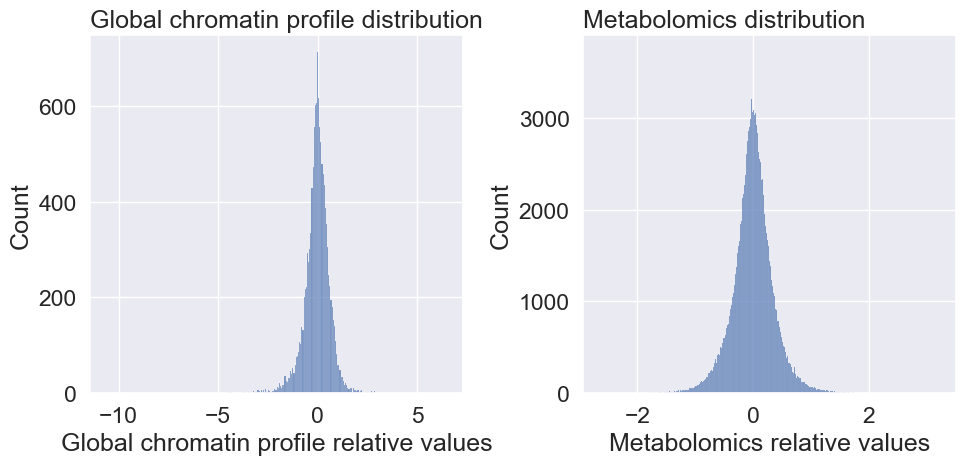

In [24]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(10, 5), 
                       dpi=100)

tmp = pd.melt(gcp_df)['value']
tmp2 = pd.melt(met_df)['value']

sns.histplot(tmp, ax=ax[0])
ax[0].set_title("Global chromatin profile distribution", loc='left')
ax[0].set_xlabel("Global chromatin profile relative values")

sns.histplot(tmp2, ax=ax[1])
ax[1].set_title("Metabolomics distribution", loc='left')
ax[1].set_xlabel("Metabolomics relative values")
plt.tight_layout()

# 5. Correlation analyses
We'll compute the Pearson Correlation Coefficients (PCC) between each global chromatin profiles and metabolite pair. Then we'll compute the corresponding P-value.


### A. Define the PCC for two sets of dataframes.
First, let's define a function that will compute the PCC and the two-tailed p-value between two matrix columns.

In [25]:
from scipy.stats import pearsonr

def calculate_PCC(df1: pd.DataFrame, df2: pd.DataFrame):
  """
  INPUTS:
    * df1: Pandas dataframe containing only numerical values.
    * df2: Pandas dataframe containing only numerical values.
  OUTPUT:
    * pcc: Numpy array containing pearson correlation coefficients between df1 
           and df2 columns.
    * pval: Numpy array containing p-values corresponding to PCCs.
  """
  # Initialize variables
  pcc = np.zeros((df1.shape[1], df2.shape[1]))
  pval = np.zeros((df1.shape[1], df2.shape[1]))
  
  # Compute PCCs and P-values
  i = 0
  for col1 in df1.columns:
    j = 0
    for col2 in df2.columns:
      [r, p] = pearsonr(df1[col1], df2[col2])
      pcc[i, j] = r
      pval[i, j] = p
      j += 1
    i +=1
  return pcc, pval

def two_df_correlation(df1: pd.DataFrame, df2: pd.DataFrame):
  pcc, pval = calculate_PCC(df1, df2)
  new_pcc_df = pd.DataFrame(pcc, 
                   index=df1.columns, 
                   columns=df2.columns)
  new_pval_df = pd.DataFrame(pval, 
                   index=df1.columns, 
                   columns=df2.columns)
  
  return new_pcc_df, new_pval_df


### B. GCP and Metabolomics Correlations for All Metabolites
Now let's get our PCC and P-value

In [26]:
gcpMetPCCAll, gcpMetPvalAll = two_df_correlation(gcp_df, met_df)

Print out the shapes of the dataframes for reference.

In [27]:
print(f"The number of GCPs are {len(gcp_df.columns)} and the number of metabolites are {len(met_df.columns)}")
print(f"The number of significant PCCs are {np.sum(np.sum(gcpMetPvalAll < 0.05))} out of {len(gcp_df.columns) * len(met_df.columns)} total PCCs")

The number of GCPs are 20 and the number of metabolites are 225
The number of significant PCCs are 710 out of 4500 total PCCs


### C. Metabolomics and Drug AUC Correlations for all metabolites
Frist, we need to make a table that resembles the metabolomics and PTM datasets for the AUC data.

In [28]:
auc_table = pd.pivot_table(
    values='area_under_sensitivity_curve', 
    index='DepMap_ID', 
    columns='compound_name',
    data=ctrp_auc
)
auc_table = auc_table.sort_values(by='DepMap_ID')

auc_table = auc_table.loc[auc_table.index.intersection(met_df.index), :]
met_df = met_df.loc[met_df.index.intersection(auc_table.index), :]
gcp_df = gcp_df.loc[gcp_df.index.intersection(auc_table.index), :]

print(auc_table.shape)
auc_table.head(5)

(622, 34)


compound_name,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,BRD-K66532283,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,14.877,13.529,14.585,11.594,12.278,13.570,14.566,17.518,8.9811,11.048,...,9.434,NaN,9.7167,NaN,NaN,14.211,NaN,NaN,14.602,10.233
ACH-000007,14.366,13.048,15.191,13.698,16.100,14.687,14.367,16.402,17.1980,15.309,...,11.623,NaN,11.2560,NaN,NaN,14.360,NaN,NaN,14.780,11.618
ACH-000008,14.895,14.382,14.658,NaN,14.713,14.547,14.804,14.866,14.0280,NaN,...,10.995,11.7150,10.9320,14.912,14.093,14.922,15.000,14.550,NaN,12.997
ACH-000009,14.592,11.629,15.079,NaN,15.367,13.659,15.821,13.819,13.4840,12.622,...,10.113,9.5299,12.8540,15.000,13.144,13.242,12.562,14.188,NaN,11.798
ACH-000011,15.176,13.313,14.362,12.334,14.171,14.164,13.963,14.309,13.1370,13.414,...,10.243,NaN,11.5860,NaN,NaN,13.816,NaN,NaN,NaN,10.934


Need to fill in missing values. While you can perform KNNimputation, let's just fill in with 30s for now, where 30 is defined as having no sensitivity.

In [29]:
auc_imputer = KNNImputer()
auc_table_imputed = met_imputer.fit_transform(auc_table)
auc_table = pd.DataFrame(auc_table_imputed, index=auc_table.index, columns=auc_table.columns)
#auc_table = auc_table.fillna(30)

Calculate the correlation between AUC and metabolomics values

In [30]:
aucMetPCCAll, aucMetPvalAll = two_df_correlation(auc_table, met_df)

In [31]:
aucMetPvalAll.head(3)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
compound_name,,,,,,,,,,,,,,,,,,,,,
AGK-2,0.054616,0.740240,0.967620,0.696691,0.595899,0.822863,0.771611,0.998719,0.573293,0.362740,...,0.489669,0.011143,0.179235,0.266059,0.123123,0.207138,0.440791,0.175720,0.205138,0.136576
BIX-01294,0.654644,0.001407,0.074223,0.757465,0.000003,0.657122,0.039858,0.016384,0.003236,0.000607,...,0.277628,0.096615,0.002734,0.001300,0.002410,0.174182,0.398638,0.070896,0.141256,0.074840
BRD-A02303741,0.058651,0.195489,0.059232,0.019229,0.272303,0.328691,0.286507,0.057538,0.021420,0.600406,...,0.055379,0.015286,0.002590,0.010279,0.024730,0.257341,0.664198,0.000088,0.000891,0.000732


Summarize the correlations

In [32]:
print(f"The number of drugs are {len(auc_table.columns)} and the number of metabolites are {len(met_df.columns)}")
print(f"The number of significant PCCs are {np.sum(np.sum(aucMetPvalAll < 0.05))} out of {len(auc_table.columns) * len(met_df.columns)} total PCCs")

The number of drugs are 34 and the number of metabolites are 225
The number of significant PCCs are 1955 out of 7650 total PCCs


Calculate the correlation between AUC and GCP values

In [33]:
aucGcpPCC, aucGcpPval = two_df_correlation(auc_table, gcp_df)

In [34]:
tmp1 = aucGcpPCC
tmp2 =aucGcpPval

tmp1 = tmp1.reset_index()
tmp1 = tmp1.rename({'compound_name':'Drug'}, axis=1)

tmp2 = tmp2.reset_index()
tmp2 = tmp2.rename({'compound_name':'Drug'}, axis=1)

tmp1 = pd.melt(frame=tmp1, id_vars='Drug', var_name='Histone PTM', value_name='PCC')
tmp2 = pd.melt(frame=tmp2, id_vars='Drug', var_name='Histone PTM', value_name='P-Value')
tmp2['FDR'] = fdrcorrection(tmp2['P-Value'], is_sorted=False)[1]

tmp3 = pd.merge(tmp1, tmp2, how='inner', left_on=['Drug', 'Histone PTM'], right_on=['Drug', 'Histone PTM'])
tmp3.to_csv('D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/tables/GcpAucPCC.csv')

In [35]:
print(f"The number of drugs are {len(auc_table.columns)} and the number of histone PTMs are {len(gcp_df.columns)}")
print(f"The number of significant PCCs are {np.sum(np.sum(aucGcpPval < 0.05))} out of {len(auc_table.columns) * len(gcp_df.columns)} total PCCs")

The number of drugs are 34 and the number of histone PTMs are 20
The number of significant PCCs are 144 out of 680 total PCCs


## 6. Visualize the data

### A. Subset the metabolites to visualize
Let's also grab data we'll need to filter out the entire matrix.

In [36]:
tmp = pd.read_excel(DATA_PATH, sheet_name="Metabolomics_NonFat")
non_fat_metabolites = tmp.columns[2:].to_list()

### B. Histograms of the data distribution
Let's view the distribution of the PCCs and P-values.

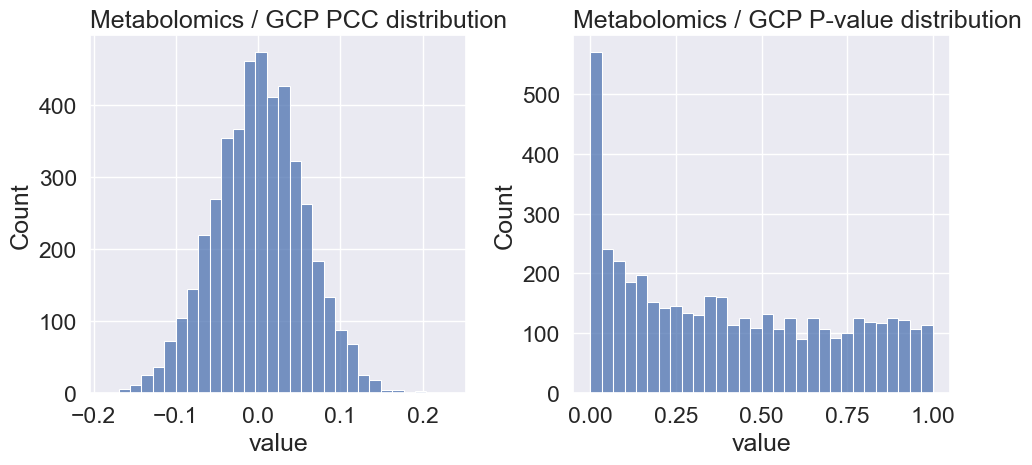

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(10, 5), dpi=100)

tmp = pd.melt(gcpMetPCCAll)['value']
tmp2 = pd.melt(gcpMetPvalAll)['value']

sns.histplot(tmp, bins=30, ax=ax[0])
ax[0].set_title("Metabolomics / GCP PCC distribution", loc='left')
sns.histplot(tmp2, bins=30, ax=ax[1])
ax[1].set_title("Metabolomics / GCP P-value distribution", loc='left')
plt.tight_layout()

### C. Barplots for importance

In [38]:
def generate_heatmap_df(pcc_df:pd.DataFrame, pval_df:pd.DataFrame, columns_to_subset:list=None, alpha:float=0.05):
    """Creates barplots of significant relationships."""
    hm_matrix = pcc_df.copy()
    pval_matrix = pval_df.copy()
    hm_matrix[pval_df > alpha] = np.nan
    if columns_to_subset:
        hm_matrix = hm_matrix[columns_to_subset]
        pval_matrix = pval_matrix[columns_to_subset]
        pcc_df = pcc_df[columns_to_subset]
    return hm_matrix.transpose(), pval_matrix.transpose(), pcc_df.transpose()

#### i. Number of PTMs -> metabolites (all metabolites)
Now, let's try to generate some static heatmaps. First, visualize everything.

In [39]:
gcpMetHmAll, _, _  = generate_heatmap_df(gcpMetPCCAll, gcpMetPvalAll)
gcpMetHmAll.head(3)

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
2-aminoadipate,NaN,NaN,NaN,NaN,NaN,NaN,0.163008,NaN,NaN,NaN,0.123275,0.120821,0.091013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3-phosphoglycerate,-0.103323,-0.082512,NaN,NaN,-0.086452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108054,NaN,NaN,NaN,NaN,NaN,NaN
alpha-glycerophosphate,NaN,0.102526,0.094165,NaN,NaN,NaN,NaN,0.089998,0.079562,0.105833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
gcpMetPCCAll

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
H3K4me1,0.003070,-0.103323,0.073441,0.080854,-0.004656,0.045452,0.037889,0.042466,-0.005380,0.004517,...,-0.068412,-0.008939,-0.027038,-0.074062,-0.080442,-0.103930,-0.088755,-0.033178,-0.042937,-0.053426
H3K4me2,-0.019367,-0.082512,0.102526,0.041250,-0.034734,0.024109,0.079480,-0.001522,-0.020264,-0.037522,...,0.012446,0.040303,0.020990,0.007706,-0.023380,-0.072626,-0.028252,0.027029,0.029634,0.035656
H3K4ac1,0.031675,-0.010203,0.094165,0.009547,-0.021633,0.008016,0.035930,0.060008,0.013909,-0.008853,...,-0.035032,-0.066616,-0.059009,-0.053655,-0.015712,-0.031352,-0.067875,-0.073242,-0.045091,-0.054339
H3K9me1,0.019246,-0.030036,-0.030985,-0.036861,0.003756,0.026122,0.060076,0.008633,-0.044024,0.008940,...,-0.002632,0.012747,0.007230,-0.017406,-0.044983,-0.046259,-0.031188,0.059881,0.047568,-0.003153
H3K9me2,-0.037098,-0.086452,-0.040283,0.010398,-0.069264,0.047959,0.032055,-0.006391,-0.099505,-0.063333,...,-0.024345,0.038051,0.046871,0.000472,-0.002421,-0.013629,-0.018075,0.051150,0.034248,0.028533
H3K9me3,-0.056529,-0.009824,-0.001807,-0.008892,0.008401,-0.030393,-0.031807,-0.038240,-0.136209,-0.016561,...,0.007948,0.043892,0.026646,-0.029202,-0.030369,0.007849,-0.019511,0.061817,0.062382,0.034992
H3K9ac1,0.163008,0.057445,0.073409,-0.030044,0.034744,-0.007112,-0.013445,0.038756,0.051851,0.019310,...,-0.115923,-0.130568,-0.099404,-0.114496,-0.094697,-0.087711,-0.085730,-0.111573,-0.105095,-0.131565
H3K14ac1,0.067525,0.056989,0.089998,-0.011533,0.024107,0.006503,0.052226,0.042865,0.115565,0.043571,...,-0.056417,-0.088622,-0.080079,-0.066966,-0.080906,-0.088962,-0.043782,-0.076798,-0.087126,-0.097506
H3K18ac1,-0.010599,0.050133,0.079562,-0.008407,0.052998,0.014190,0.027273,0.058888,0.046239,0.090393,...,-0.062194,-0.072058,-0.104289,-0.111260,-0.102716,-0.089976,-0.053438,-0.088988,-0.100746,-0.107269
H3K23ac1,0.077032,-0.017485,0.105833,0.055426,-0.007655,0.040444,0.029250,0.022515,0.139529,0.049235,...,-0.087874,-0.051917,-0.078687,-0.046518,-0.053779,-0.060235,-0.022648,-0.075327,-0.087469,-0.085577


Format the data that will be visualized.

In [41]:
gcpMetImportanceAll = len(gcp_df.columns) - gcpMetHmAll.isna().sum(axis=1)
gcpMetImportanceAll = pd.DataFrame(gcpMetImportanceAll.sort_values(ascending=False), 
                                        columns=["Number of significant PTM associations"])

gcpMetImportanceAll = gcpMetImportanceAll[0:20]
gcpMetImportanceAll.shape

(20, 1)

Make the barplot

[Text(0, 0, '9'),
 Text(0, 0, '9'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '6')]

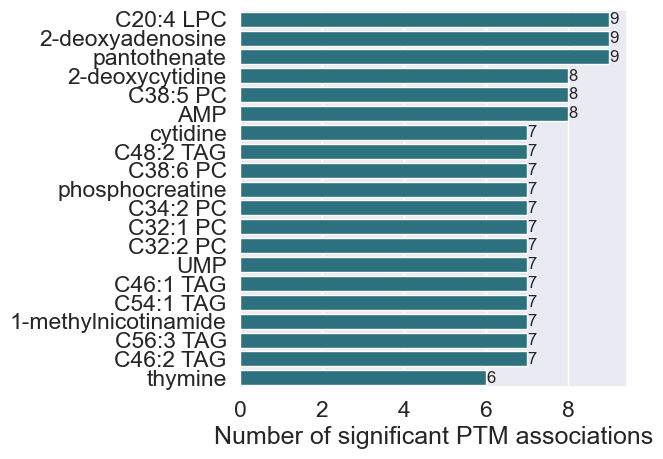

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(5, 5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=gcpMetImportanceAll, 
                y=gcpMetImportanceAll.index, 
                x='Number of significant PTM associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
#plt.title("Top 20 metabolites associated with significant PTM correlations", 
#            loc='left', 
#            fontdict = {'fontsize' : 16}
#)


Now let's make the heatmap with grouped objects.

In [43]:
def prep_clustergram_data(pcc:pd.DataFrame, \
                          pval:pd.DataFrame, \
                          index_filter:list=None, \
                          col_filter:list=None, \
                          num_rows:int=None, \
                          num_cols:int=None, \
                          alpha:float=0.05):
    """
    """
    tmp = pcc.copy()
    mask = pval.copy()
    tmp = tmp.transpose()
    mask = mask.transpose()

    if index_filter is not None:
        tmp = tmp.loc[tmp.index.isin(index_filter), :]
        mask = mask.loc[mask.index.isin(index_filter), :]
    if col_filter is not None:
        tmp = tmp.loc[:, tmp.columns.isin(col_filter)]
        mask = mask.loc[:, tmp.columns.isin(col_filter)]
    if num_rows:
        tmp = tmp.iloc[0:num_rows, :]
        mask = mask.iloc[0:num_rows, :]
    if num_cols:
        tmp = tmp.iloc[:, 0:num_cols]
        mask = mask.iloc[:, 0:num_cols]
    mask = mask > alpha
    tmp = tmp.reindex(index_filter)
    mask = mask.reindex(index_filter)
    return tmp, mask

def split_into_ptm_groups(df:pd.DataFrame, mask:pd.DataFrame):
    """
    """
    df = df.round(2)
    ac_df = df[[x for x in df.columns if 'ac1' in x]]
    me_df = df[[x for x in df.columns if 'me' in x]]

    ac_mask = mask[[x for x in mask.columns if 'ac1' in x]]
    me_mask = mask[[x for x in mask.columns if 'me' in x]]

    vmin = min(ac_df.values.min(), me_df.values.min())
    vmax = max(ac_df.values.max(), me_df.values.max())
    sns.set(font_scale=2)
    _, axs = plt.subplots(
        ncols=2, 
        sharey=True, 
        figsize=(15, 15), 
        gridspec_kw=dict(width_ratios=[0.9, 2.625], height_ratios=[1])
    )

    sns.heatmap(
        ac_df, 
        cmap='RdYlBu_r', 
        mask=ac_mask, 
        annot_kws={"size": 12},
        annot=True,
        square=True,
        ax=axs[0],
        vmin=vmin,
        vmax=vmax,
        cbar=False)

    sns.heatmap(
        me_df, 
        #figsize=(20, 20), 
        cmap='RdYlBu_r', 
        mask=me_mask, 
        annot_kws={"size": 12},
        annot=True,
        square=True,
        vmin=vmin,
        vmax=vmax,
        ax=axs[1],
        cbar_kws={
                    "shrink": 0.35,
                    "label": "PCC"
        })


    axs[0].set_facecolor('black')
    axs[1].set_facecolor('black')
    #plt.rcParams.update({'font.size':18})
    plt.tight_layout()


Create the grouped object

In [44]:
tmp, mask = prep_clustergram_data(
    gcpMetPCCAll, 
    gcpMetPvalAll, 
    index_filter=gcpMetImportanceAll.index, 
    num_rows=20
)

In [45]:
tmp

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
C20:4 LPC,0.090964,0.081020,0.031380,0.044772,0.021231,0.034032,0.082926,0.093587,0.064316,0.091328,0.106379,0.111464,0.064608,0.085588,0.039060,0.032314,0.106451,0.070384,0.018866,-0.022825
2-deoxyadenosine,-0.122951,-0.065083,-0.037636,0.006754,-0.089226,-0.128033,0.165473,0.123140,-0.050870,0.129322,0.119711,0.059992,0.044578,0.127790,0.026407,-0.034389,0.127614,-0.009882,-0.071586,-0.025128
pantothenate,0.147960,0.089160,0.110686,-0.011971,-0.035190,-0.075408,0.179554,0.201979,0.072912,0.232455,0.014406,0.008407,0.010451,-0.061356,0.049926,0.196388,0.105953,0.038574,0.072416,0.138531
2-deoxycytidine,0.087217,0.083330,0.031904,-0.080379,0.000553,-0.124085,0.134692,0.035911,-0.000137,0.081054,0.020127,0.052154,0.005420,-0.145148,-0.058987,0.044381,0.004178,0.013668,0.063359,0.097434
C38:5 PC,-0.004025,0.079618,-0.031818,0.068133,0.086360,0.075011,-0.106771,-0.075577,-0.043323,-0.106219,0.088877,0.092646,0.067192,0.060804,-0.000638,-0.011699,0.003644,-0.033777,0.099879,0.118128
AMP,-0.005380,-0.020264,0.013909,-0.044024,-0.099505,-0.136209,0.051851,0.115565,0.046239,0.139529,-0.133197,-0.072356,-0.089026,-0.108978,0.018146,0.119336,0.003545,-0.023578,-0.018134,-0.021486
cytidine,0.089751,0.103253,0.017057,-0.076278,-0.029945,-0.116843,0.135713,0.049865,-0.018117,0.112235,-0.007129,0.074600,-0.012901,-0.183514,-0.090735,0.037679,-0.055783,0.030103,0.007347,0.006618
C48:2 TAG,0.007965,-0.022904,0.019489,-0.116534,-0.124042,-0.139314,0.003914,0.097938,0.027324,0.112283,-0.089323,-0.031374,-0.070679,-0.102888,-0.001744,0.035113,0.036807,0.004823,-0.027145,-0.059311
C38:6 PC,0.009685,0.084415,-0.033641,0.084978,0.105467,0.076987,-0.104440,-0.040291,-0.024051,-0.089474,0.070373,0.069166,0.056449,0.032163,-0.007047,0.023721,-0.001746,-0.060758,0.131539,0.144763
phosphocreatine,-0.014486,-0.072123,0.040237,-0.019051,-0.095540,-0.072916,0.007948,0.104030,0.078581,0.123141,-0.011137,0.000010,0.024323,0.039411,0.004420,-0.000256,0.106349,-0.069593,-0.084862,-0.104210


Visualize the data.

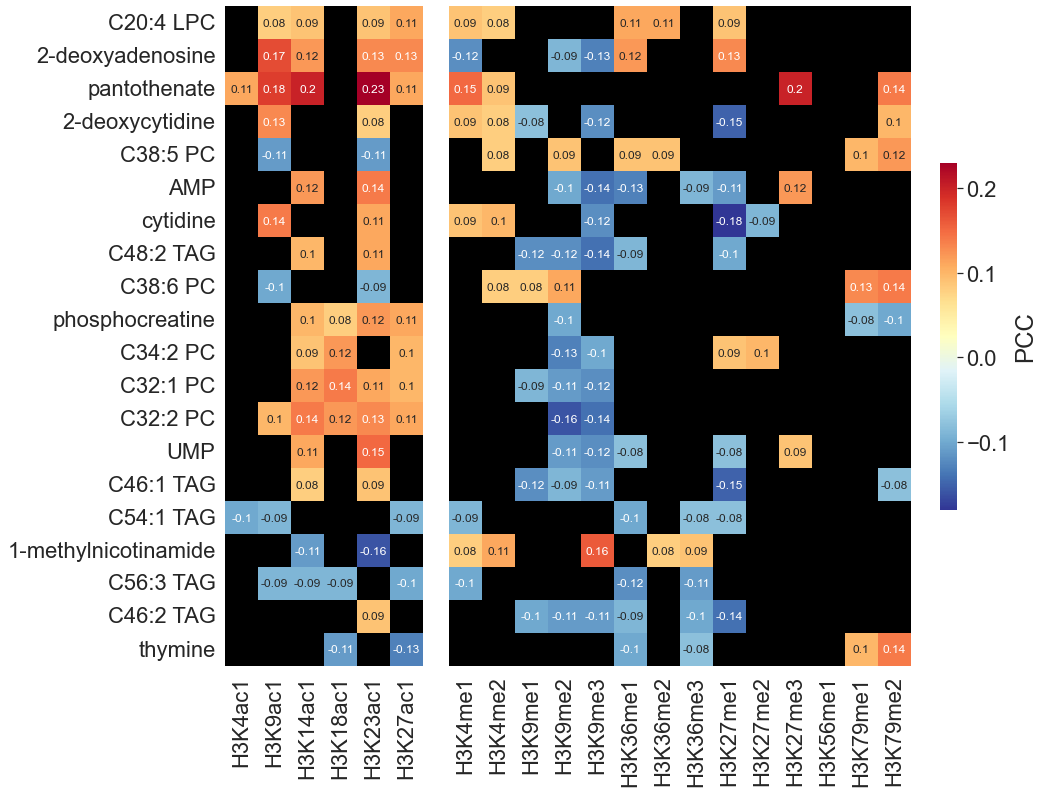

In [46]:
split_into_ptm_groups(tmp, mask)

#### ii. Number of metabolites -> PTMs (all metabolites)

In [47]:
metGCPImportanceAll = len(gcpMetHmAll.index) - gcpMetHmAll.isna().sum(axis=0)
metGCPImportanceAll = pd.DataFrame(
    metGCPImportanceAll.sort_values(ascending=False), 
    columns=["Number of significant metabolite associations"]
)

[Text(0, 0, '66'),
 Text(0, 0, '60'),
 Text(0, 0, '55'),
 Text(0, 0, '54'),
 Text(0, 0, '51'),
 Text(0, 0, '49'),
 Text(0, 0, '46'),
 Text(0, 0, '46'),
 Text(0, 0, '42'),
 Text(0, 0, '33'),
 Text(0, 0, '33'),
 Text(0, 0, '32'),
 Text(0, 0, '29'),
 Text(0, 0, '28'),
 Text(0, 0, '25'),
 Text(0, 0, '18'),
 Text(0, 0, '15'),
 Text(0, 0, '12'),
 Text(0, 0, '10'),
 Text(0, 0, '6')]

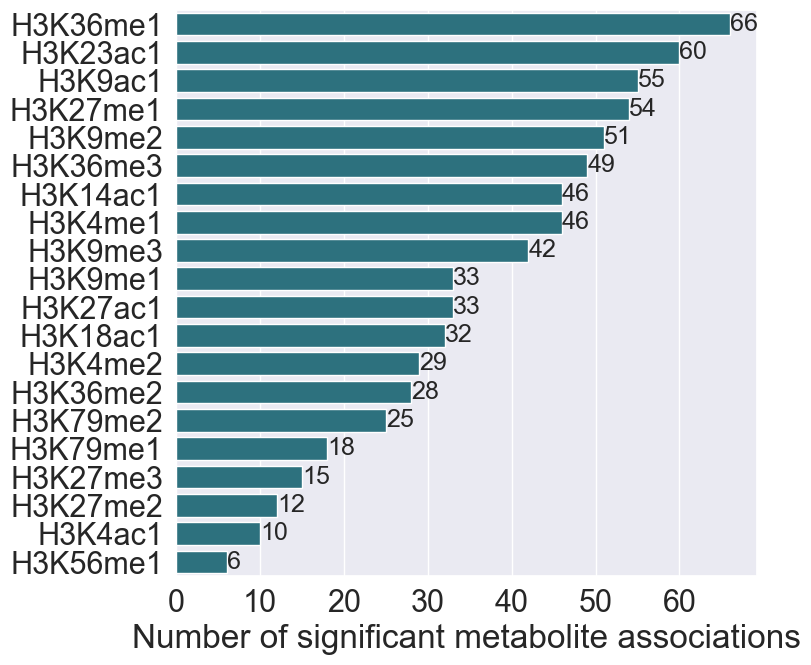

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(7.5, 7.5), dpi=100)
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
ax = sns.barplot(data=metGCPImportanceAll, 
                y=metGCPImportanceAll.index, 
                x='Number of significant metabolite associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
#plt.title("Histone PTMs associated with significant metabolite correlations", loc='left', fontdict = {'fontsize' : 16})

#### iii. Number of AUCs -> metabolites (all metabolites)

In [49]:
aucMetHmAll, _, _  = generate_heatmap_df(aucMetPCCAll, aucMetPvalAll)
aucMetHmAll.head(3)

compound_name,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,BRD-K66532283,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
2-aminoadipate,NaN,NaN,NaN,0.097305,NaN,NaN,NaN,NaN,0.081414,NaN,...,0.087101,NaN,NaN,NaN,NaN,NaN,NaN,0.086596,NaN,NaN
3-phosphoglycerate,NaN,0.127765,NaN,0.133958,NaN,0.143864,NaN,NaN,NaN,0.094807,...,0.102433,NaN,0.082738,NaN,0.092067,NaN,NaN,0.171105,NaN,NaN
alpha-glycerophosphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
aucMetImportanceAll = len(auc_table.columns) - aucMetHmAll.isna().sum(axis=1)
aucMetImportanceAll = pd.DataFrame(
    aucMetImportanceAll.sort_values(ascending=False), 
    columns=["Number of significant drug associations"]
)
aucMetImportanceAll = aucMetImportanceAll[0:20]
aucMetImportanceAll.shape
aucMetImportanceAll

,Number of significant drug associations
C52:4 TAG,22
C48:1 TAG,21
1-methylnicotinamide,21
xanthosine,21
sorbitol,20
C52:5 TAG,20
NADP,20
C52:2 TAG,19
lactate,19
C52:1 TAG,19


[Text(0, 0, '22'),
 Text(0, 0, '21'),
 Text(0, 0, '21'),
 Text(0, 0, '21'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '18'),
 Text(0, 0, '17')]

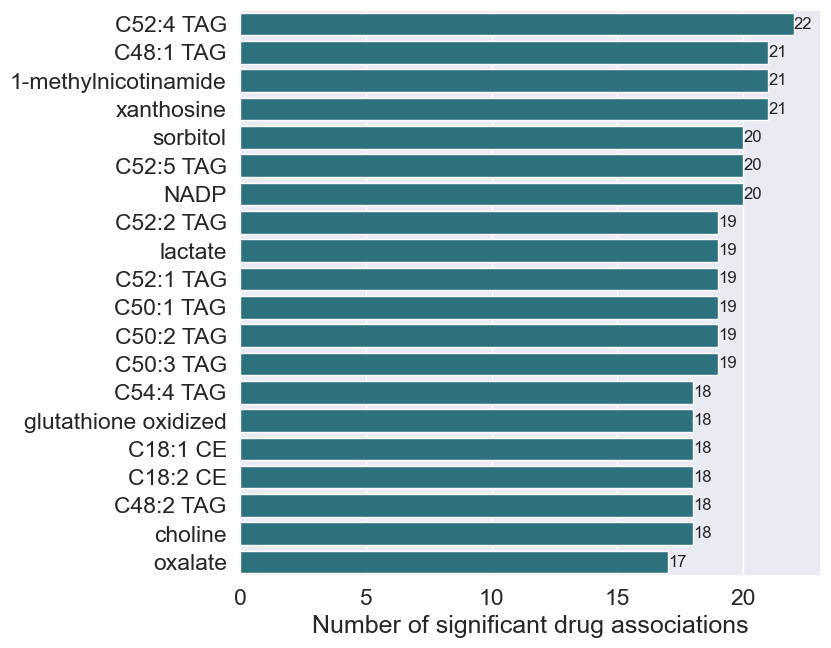

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(7.5, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=aucMetImportanceAll, 
                y=aucMetImportanceAll.index, x='Number of significant drug associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
#plt.title("Top 20 metabolites associated with significant drug correlations", loc='left', fontdict = {'fontsize' : 16})

#### iv. Number of metabolites -> AUCs (all metabolites)

In [52]:
metAucImportanceAll = len(met_df.columns) - aucMetHmAll.isna().sum(axis=0)
metAucImportanceAll = pd.DataFrame(
    metAucImportanceAll.sort_values(ascending=False), 
    columns=["Number of significant metabolite associations"]
)
metAucImportanceAll = metAucImportanceAll[0:20]

In [53]:
metAucImportanceAll = pd.merge(
    metAucImportanceAll, tmp_uniq_cmpds, 
    how='inner', 
    left_index=True, right_on='compound_name'
)

In [54]:
metAucImportanceAll["Name, Type"] = metAucImportanceAll["compound_name"].astype(str).str.cat(metAucImportanceAll["Type"].astype(str), sep=", ")

Text(0.5, 1.0, 'Histone PTM drugs associated with significant metabolite correlations')

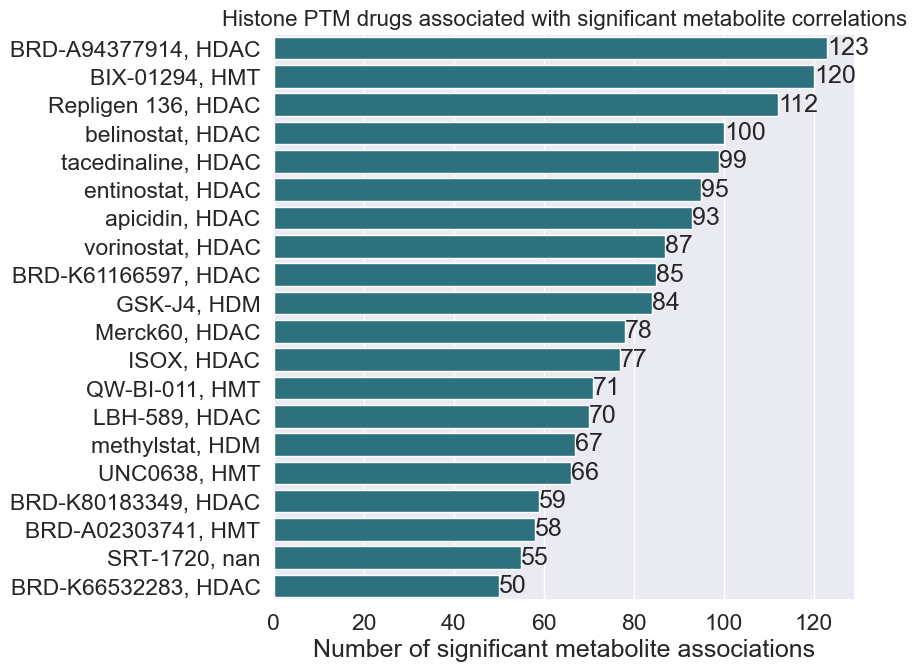

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(7.5, 7.5), dpi=100)
sns.set(font_scale=1.5)
sns.set_style('darkgrid')    

ax_bar = sns.barplot(data=metAucImportanceAll, 
                orientation='horizontal',
                y='Name, Type', 
                x='Number of significant metabolite associations',
                color="#1F7A8C",
                ax=ax)
ax_bar.set(ylabel='')
ax_bar.bar_label(ax.containers[0])

plt.title(
    "Histone PTM drugs associated with significant metabolite correlations", 
    fontdict = {'fontsize' : 16})


In [56]:
auc_met_pcc_subset = aucMetPCCAll.loc[aucMetPCCAll.index.str.contains('|'.join(metAucImportanceAll["Name, Type"].str.split(',').str[0])), :]
#auc_met_pcc_subset = auc_met_pcc_subset.set_index('compound_name')
auc_met_pval_subset = aucMetPvalAll.loc[aucMetPvalAll.index.str.contains('|'.join(metAucImportanceAll["Name, Type"].str.split(',').str[0])), :]
#auc_met_pval_subset = auc_met_pval_subset.set_index('compound_name')

drug_importance_subset = metAucImportanceAll.loc[metAucImportanceAll['compound_name'].isin(auc_met_pval_subset.index), :]

In [57]:
auc_met_pcc_subset.loc[:, aucMetImportanceAll.index[:19].to_list()]

,C52:4 TAG,C48:1 TAG,1-methylnicotinamide,xanthosine,sorbitol,C52:5 TAG,NADP,C52:2 TAG,lactate,C52:1 TAG,C50:1 TAG,C50:2 TAG,C50:3 TAG,C54:4 TAG,glutathione oxidized,C18:1 CE,C18:2 CE,C48:2 TAG,choline
compound_name,,,,,,,,,,,,,,,,,,,
BIX-01294,-0.156803,-0.089957,0.114096,0.085676,0.151276,-0.128398,0.152966,-0.096555,0.127473,-0.065431,-0.065538,-0.099779,-0.149309,-0.122609,0.104712,0.115005,0.089503,-0.112519,-0.130458
BRD-A02303741,0.028045,-0.098369,0.061650,0.087380,0.107308,0.046997,0.001626,-0.046813,-0.030114,-0.027755,-0.079283,-0.060521,-0.021915,0.079187,-0.039641,-0.043292,0.023450,-0.052953,0.116438
BRD-A94377914,-0.213291,-0.204519,0.189060,0.159939,0.176264,-0.203747,0.137786,-0.178248,0.167952,-0.183965,-0.192062,-0.177196,-0.169777,-0.164669,0.129024,0.157641,0.148280,-0.179784,-0.146855
BRD-K61166597,-0.138320,-0.175766,0.114207,0.086780,0.173410,-0.164951,0.132201,-0.134854,0.057329,-0.159054,-0.170164,-0.146018,-0.122242,-0.099631,0.100896,0.127694,0.137433,-0.148931,-0.103497
BRD-K66532283,-0.083693,-0.130333,0.120929,0.033067,0.119099,-0.080184,0.091758,-0.080177,0.065365,-0.102884,-0.116699,-0.089927,-0.065028,-0.058660,0.057899,0.064295,0.062003,-0.104574,-0.184799
BRD-K80183349,-0.091990,-0.132705,0.177404,0.041125,0.085321,-0.102430,0.074896,-0.111099,0.124016,-0.081986,-0.114654,-0.129744,-0.111324,-0.071745,0.100319,0.106582,0.090710,-0.137754,-0.152811
GSK-J4,-0.160857,-0.207753,0.172369,0.109856,0.203353,-0.122138,0.154505,-0.190886,0.128491,-0.170162,-0.205777,-0.188463,-0.167587,-0.112829,0.119531,0.093793,0.132424,-0.181774,-0.055114
ISOX,-0.127091,-0.171753,0.131795,0.091089,0.125561,-0.151715,0.101228,-0.129167,0.111356,-0.140739,-0.167454,-0.147413,-0.103905,-0.090526,0.117662,0.090583,0.090669,-0.143643,-0.120274
LBH-589,-0.155975,-0.228185,0.227173,0.104156,0.168292,-0.143692,0.071015,-0.155307,0.107409,-0.153399,-0.202027,-0.185118,-0.166613,-0.094552,0.027399,0.107303,0.131295,-0.207295,-0.083262


In [58]:
tmp, mask = prep_clustergram_data(auc_met_pcc_subset, \
                                    auc_met_pval_subset, \
                                    index_filter = aucMetImportanceAll.index[:20].to_list(), \
                                    col_filter = drug_importance_subset['compound_name'].to_list(), \
                                    num_rows=20, \
                                    num_cols=20,
                                    alpha=0.01)
tmp.columns = drug_importance_subset["Name, Type"]
mask.columns = drug_importance_subset["Name, Type"]

print(tmp.shape)
tmp

(20, 20)


"Name, Type","BRD-A94377914, HDAC","BIX-01294, HMT","Repligen 136, HDAC","belinostat, HDAC","tacedinaline, HDAC","entinostat, HDAC","apicidin, HDAC","vorinostat, HDAC","BRD-K61166597, HDAC","GSK-J4, HDM","Merck60, HDAC","ISOX, HDAC","QW-BI-011, HMT","LBH-589, HDAC","methylstat, HDM","UNC0638, HMT","BRD-K80183349, HDAC","BRD-A02303741, HMT","SRT-1720, nan","BRD-K66532283, HDAC"
C52:4 TAG,-0.156803,0.028045,-0.213291,-0.138320,-0.083693,-0.091990,-0.160857,-0.127091,-0.155975,-0.136403,-0.122574,-0.121138,-0.087096,-0.071652,-0.144030,-0.161706,-0.144926,-0.111967,-0.129300,-0.136382
C48:1 TAG,-0.089957,-0.098369,-0.204519,-0.175766,-0.130333,-0.132705,-0.207753,-0.171753,-0.228185,-0.207860,-0.124003,-0.119481,-0.079157,-0.068198,-0.170321,-0.205593,-0.221007,-0.106212,-0.148868,-0.226588
1-methylnicotinamide,0.114096,0.061650,0.189060,0.114207,0.120929,0.177404,0.172369,0.131795,0.227173,0.106216,0.049507,0.174658,0.060694,0.032310,0.141014,0.218177,0.150978,0.046851,0.168622,0.207541
xanthosine,0.085676,0.087380,0.159939,0.086780,0.033067,0.041125,0.109856,0.091089,0.104156,0.130962,0.151437,0.125250,0.114872,0.088375,0.134520,0.114870,0.102647,0.121895,0.100930,0.157830
sorbitol,0.151276,0.107308,0.176264,0.173410,0.119099,0.085321,0.203353,0.125561,0.168292,0.140941,0.129782,0.180493,0.043708,0.095224,0.153100,0.155954,0.148363,0.108229,0.138487,0.163936
C52:5 TAG,-0.128398,0.046997,-0.203747,-0.164951,-0.080184,-0.102430,-0.122138,-0.151715,-0.143692,-0.135950,-0.130097,-0.153063,-0.099121,-0.045934,-0.166212,-0.153918,-0.135550,-0.108229,-0.153910,-0.144773
NADP,0.152966,0.001626,0.137786,0.132201,0.091758,0.074896,0.154505,0.101228,0.071015,0.118887,0.090303,0.082768,0.084765,0.144732,0.129081,0.087126,0.108185,0.220388,0.137515,0.085597
C52:2 TAG,-0.096555,-0.046813,-0.178248,-0.134854,-0.080177,-0.111099,-0.190886,-0.129167,-0.155307,-0.158496,-0.123560,-0.127598,-0.056526,-0.053307,-0.121388,-0.160166,-0.179401,-0.098640,-0.117693,-0.184090
lactate,0.127473,-0.030114,0.167952,0.057329,0.065365,0.124016,0.128491,0.111356,0.107409,0.037051,0.035208,0.079783,0.080918,0.081811,0.117157,0.128500,0.103934,0.084206,0.111204,0.089248
C52:1 TAG,-0.065431,-0.027755,-0.183965,-0.159054,-0.102884,-0.081986,-0.170162,-0.140739,-0.153399,-0.205775,-0.120376,-0.092241,-0.051859,-0.048272,-0.154398,-0.160436,-0.194557,-0.093906,-0.138972,-0.196174


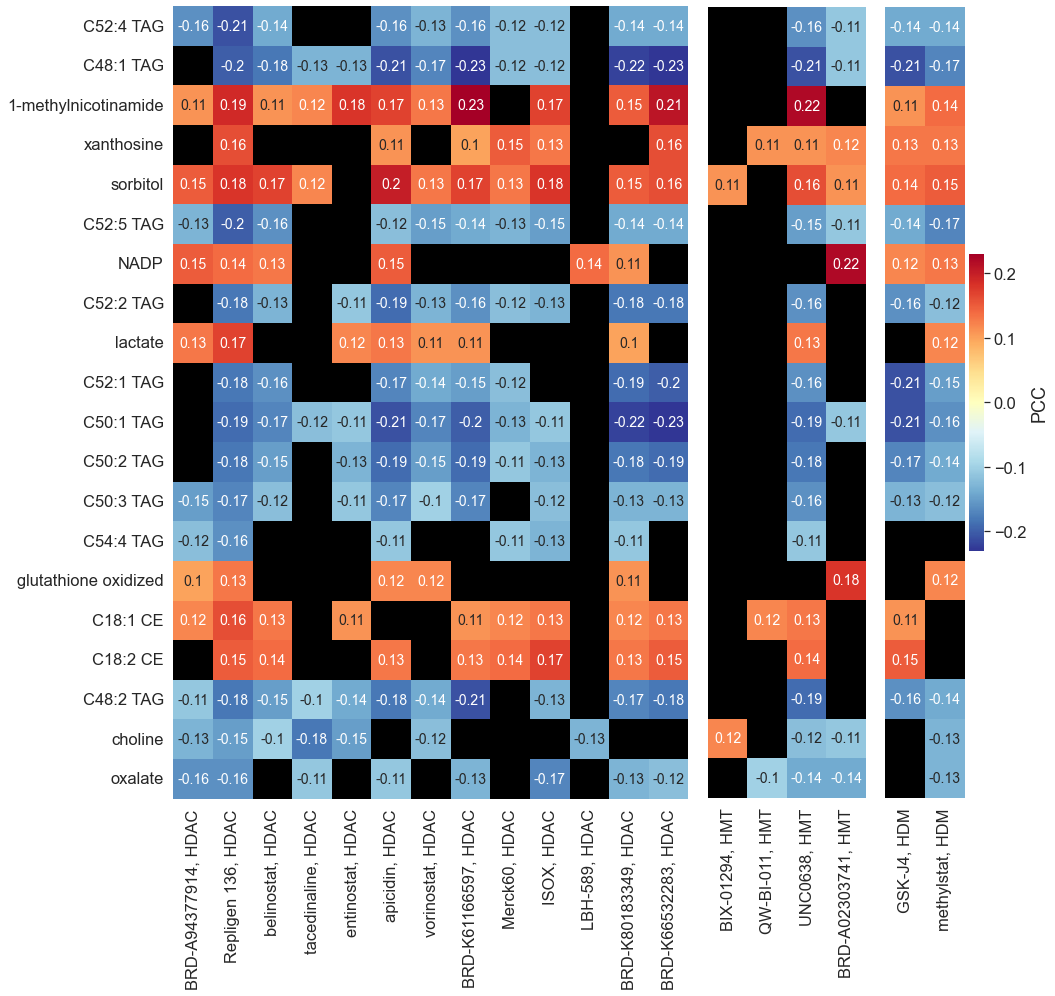

In [59]:
tmp = tmp.round(2)

hdac_df = tmp[[x for x in tmp.columns if 'HDAC' in x]]
hmt_df = tmp[[x for x in tmp.columns if 'HMT' in x]]
hdm_df = tmp[[x for x in tmp.columns if 'HDM' in x]]

hdac_df.columns.name = ''
hmt_df.columns.name = ''
hdm_df.columns.name = ''

hdac_mask = mask[[x for x in mask.columns if 'HDAC' in x]]
hmt_mask = mask[[x for x in mask.columns if 'HMT' in x]]
hdm_mask = mask[[x for x in mask.columns if 'HDM' in x]]

vmin = min([hdac_df.values.min(), hmt_df.values.min(), hdm_df.values.min()])
vmax = max([hdac_df.values.max(), hmt_df.values.max(), hdm_df.values.max()])
figs, axs = plt.subplots(
    ncols=3, 
    sharey=True, 
    figsize=(15, 15), 
    gridspec_kw=dict(width_ratios=[2, 0.614, 0.384], height_ratios=[1])
)
sns.heatmap(
    hdac_df, 
    cmap='RdYlBu_r', 
    mask=hdac_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[0],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
sns.heatmap(
    hmt_df, 
    cmap='RdYlBu_r', 
    mask=hmt_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[1],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
sns.heatmap(
    hdm_df, 
    cmap='RdYlBu_r', 
    mask=hdm_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    vmin=vmin,
    vmax=vmax,
    ax=axs[2],
    cbar_kws={
                "shrink": 0.35,
                "label": "PCC"
    })
axs[0].set_facecolor('black')
axs[1].set_facecolor('black')
axs[2].set_facecolor('black')

plt.tight_layout()

#### v. Number of AUCs -> GCPs (all metabolites)

In [60]:
aucGCPHmAll, _, _ = generate_heatmap_df(aucGcpPCC, aucGcpPval)
aucGCPHmAll.head(3)

compound_name,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,BRD-K66532283,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
H3K4me1,NaN,NaN,NaN,-0.106615,NaN,-0.091789,NaN,NaN,NaN,NaN,...,-0.106815,-0.085623,NaN,NaN,NaN,NaN,NaN,-0.095692,NaN,NaN
H3K4me2,NaN,NaN,NaN,NaN,NaN,-0.130821,NaN,NaN,NaN,NaN,...,-0.100115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H3K4ac1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
drugImportanceGcpAuc = len(aucGCPHmAll.index) - aucGCPHmAll.isna().sum(axis=0)
drugImportanceGcpAuc = pd.DataFrame(
    drugImportanceGcpAuc.sort_values(ascending=False), 
    columns=["Number of significant drug associations"]
)
drugImportanceGcpAuc = drugImportanceGcpAuc[0:20]

drugImportanceGcpAuc = pd.merge(
    drugImportanceGcpAuc, tmp_uniq_cmpds, 
    how='inner', 
    left_index=True, right_on='compound_name'
)

drugImportanceGcpAuc["Name, Type"] = drugImportanceGcpAuc["compound_name"].astype(str).str.cat(drugImportanceGcpAuc["Type"].astype(str), sep=", ")
drugImportanceGcpAuc


,Number of significant drug associations,compound_name,target_or_activity_of_compound,Type,"Name, Type"
19,11,vorinostat,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"vorinostat, HDAC"
18,11,tacedinaline,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"tacedinaline, HDAC"
14,11,apicidin,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"apicidin, HDAC"
22,10,ISOX,inhibitor of HDAC6,HDAC,"ISOX, HDAC"
15,9,belinostat,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"belinostat, HDAC"
13,9,LBH-589,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"LBH-589, HDAC"
12,7,BRD-A94377914,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"BRD-A94377914, HDAC"
7,7,BRD-K11533227,inhibitor of HDAC1 and HDAC2,HDAC,"BRD-K11533227, HDAC"
11,6,Merck60,inhibitor of HDAC1 and HDAC2,HDAC,"Merck60, HDAC"
8,6,BRD-K61166597,inhibitor of HDAC1 and HDAC2,HDAC,"BRD-K61166597, HDAC"


In [62]:
drugImportanceGcpAuc = drugImportanceGcpAuc[:-1]

C:\Users\Scott\AppData\Local\Temp/ipykernel_25104/1265490845.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Text(-231.75, 0.5, '')

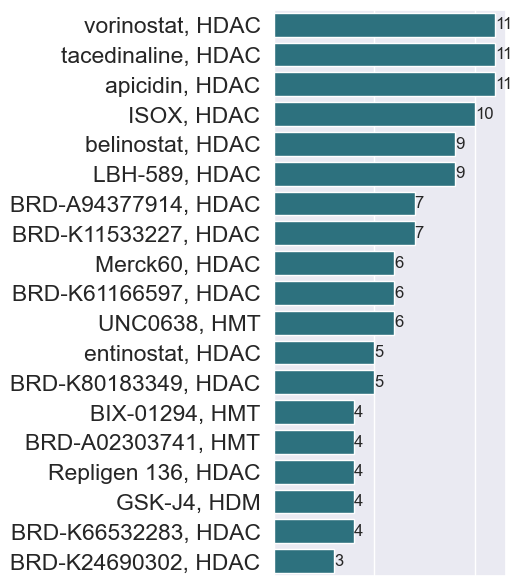

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=drugImportanceGcpAuc, 
                y='Name, Type', x='Number of significant drug associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])
plt.ylabel('')
#plt.title("GCPs associated with significant drug correlations", loc='left', fontdict = {'fontsize' : 16})

#### vi. Number of GCPs -> AUCs (all metabolites)

In [64]:
histoneImportanceGcpAuc = len(auc_table.columns) - aucGCPHmAll.isna().sum(axis=1)
histoneImportanceGcpAuc = pd.DataFrame(
    histoneImportanceGcpAuc.sort_values(ascending=False), 
    columns=["Number of significant drug associations"]
)
histoneImportanceGcpAuc = histoneImportanceGcpAuc[0:20]
histoneImportanceGcpAuc.index

Index(['H3K23ac1', 'H3K14ac1', 'H3K18ac1', 'H3K27ac1', 'H3K79me2', 'H3K36me2',
       'H3K79me1', 'H3K4me1', 'H3K36me1', 'H3K9me1', 'H3K9me3', 'H3K27me2',
       'H3K9ac1', 'H3K36me3', 'H3K4me2', 'H3K9me2', 'H3K27me1', 'H3K27me3',
       'H3K56me1', 'H3K4ac1'],
      dtype='object')

Text(-95.75, 0.5, '')

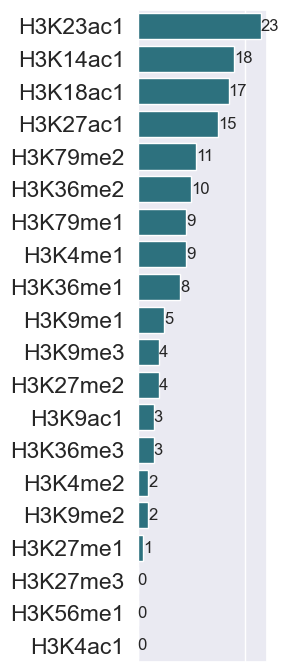

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=histoneImportanceGcpAuc, 
                y=histoneImportanceGcpAuc.index, 
                x='Number of significant drug associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])
#plt.title("PTMs associated with significant PTM drug correlations", loc='left', fontdict = {'fontsize' : 16})
plt.ylabel('')

In [66]:
aucGcpPCCSubset = aucGcpPCC.loc[aucGcpPCC.index.str.contains('|'.join(drugImportanceGcpAuc["Name, Type"].str.split(',').str[0])), :]
aucGcpPvalSubset = aucGcpPval.loc[aucGcpPval.index.str.contains('|'.join(drugImportanceGcpAuc["Name, Type"].str.split(',').str[0])), :]
drugImportanceSubsetGcpAuc = drugImportanceGcpAuc.loc[drugImportanceGcpAuc['compound_name'].isin(aucGcpPvalSubset.index), :]

In [67]:
tmp, mask = prep_clustergram_data(aucGcpPCCSubset, \
                                    aucGcpPvalSubset, \
                                    col_filter = drugImportanceSubsetGcpAuc['compound_name'], \
                                    num_rows=20, \
                                    #num_cols=20,
                                    alpha=0.05)
tmp.columns = drugImportanceGcpAuc["Name, Type"]
mask.columns = drugImportanceGcpAuc["Name, Type"]

print(tmp.shape)
tmp.index

(20, 19)


Index(['H3K4me1', 'H3K4me2', 'H3K4ac1', 'H3K9me1', 'H3K9me2', 'H3K9me3',
       'H3K9ac1', 'H3K14ac1', 'H3K18ac1', 'H3K23ac1', 'H3K36me1', 'H3K36me2',
       'H3K36me3', 'H3K27me1', 'H3K27me2', 'H3K27me3', 'H3K27ac1', 'H3K56me1',
       'H3K79me1', 'H3K79me2'],
      dtype='object')

In [68]:
tmp = tmp.round(2)

hdac_df = tmp[[x for x in tmp.columns if 'HDAC' in x]]
hmt_df = tmp[[x for x in tmp.columns if 'HMT' in x]]
hdm_df = tmp[[x for x in tmp.columns if 'HDM' in x]]

hdac_df.columns.name = ''
hmt_df.columns.name = ''
hdm_df.columns.name = ''

vmin = min([hdac_df.values.min(), hmt_df.values.min(), hdm_df.values.min()])
vmax = max([hdac_df.values.max(), hmt_df.values.max(), hdm_df.values.max()])

hdac_ac_df = hdac_df.loc[[x for x in hdac_df.index if 'ac' in x], :]
hmt_ac_df = hmt_df.loc[[x for x in hmt_df.index if 'ac' in x], :]
hdm_ac_df = hdm_df.loc[[x for x in hdm_df.index if 'ac' in x], :]

hdac_me_df = hdac_df.loc[[x for x in hdac_df.index if 'me' in x], :]
hmt_me_df = hmt_df.loc[[x for x in hmt_df.index if 'me' in x], :]
hdm_me_df = hdm_df.loc[[x for x in hdm_df.index if 'me' in x], :]

hdac_mask = mask[[x for x in mask.columns if 'HDAC' in x]]
hmt_mask = mask[[x for x in mask.columns if 'HMT' in x]]
hdm_mask = mask[[x for x in mask.columns if 'HDM' in x]]

hdac_ac_mask = hdac_mask.loc[[x for x in hdac_mask.index if 'ac' in x], :]
hmt_ac_mask = hmt_mask.loc[[x for x in hmt_mask.index if 'ac' in x], :]
hdm_ac_mask = hdm_mask.loc[[x for x in hdm_mask.index if 'ac' in x], :]

hdac_me_mask = hdac_mask.loc[[x for x in hdac_mask.index if 'me' in x], :]
hmt_me_mask = hmt_mask.loc[[x for x in hmt_mask.index if 'me' in x], :]
hdm_me_mask = hdm_mask.loc[[x for x in hdm_mask.index if 'me' in x], :]

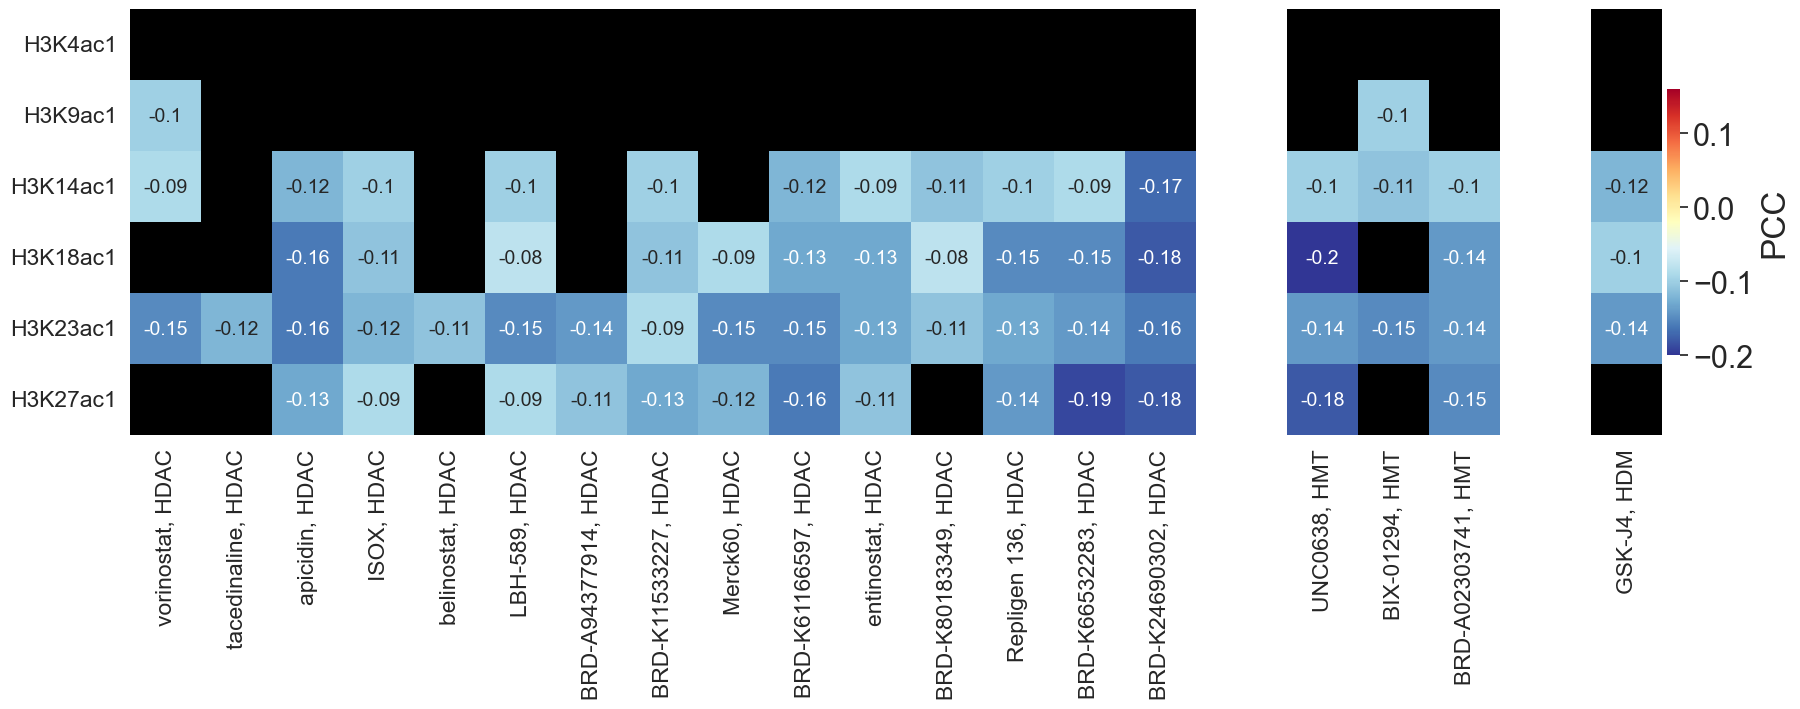

In [69]:
figs, axs = plt.subplots(
    nrows=1,
    ncols=3, 
    figsize=(20, 20), 
    #sharex='col',
    sharey=False,
    gridspec_kw=dict(width_ratios=[3, 0.6, 0.25]),
    dpi=100
)

sns.set(font_scale=2)
plt.rcParams.update({'font.size':14})

a = sns.heatmap(
    hdac_ac_df, 
    cmap='RdYlBu_r', 
    mask=hdac_ac_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[0],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
    
b = sns.heatmap(
    hmt_ac_df, 
    cmap='RdYlBu_r', 
    mask=hmt_ac_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[1],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
b.set(yticklabels=[])

c = sns.heatmap(
    hdm_ac_df, 
    cmap='RdYlBu_r', 
    mask=hdm_ac_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    vmin=vmin,
    vmax=vmax,
    ax=axs[2],
    cbar_kws={
                "shrink": 0.35,
                "label": "PCC"
    })
c.set(yticklabels=[])
c.set_xticklabels(labels=['GSK-J4, HDM'],  rotation = 90)


axs[0].set_facecolor('black')
axs[1].set_facecolor('black')
axs[2].set_facecolor('black')


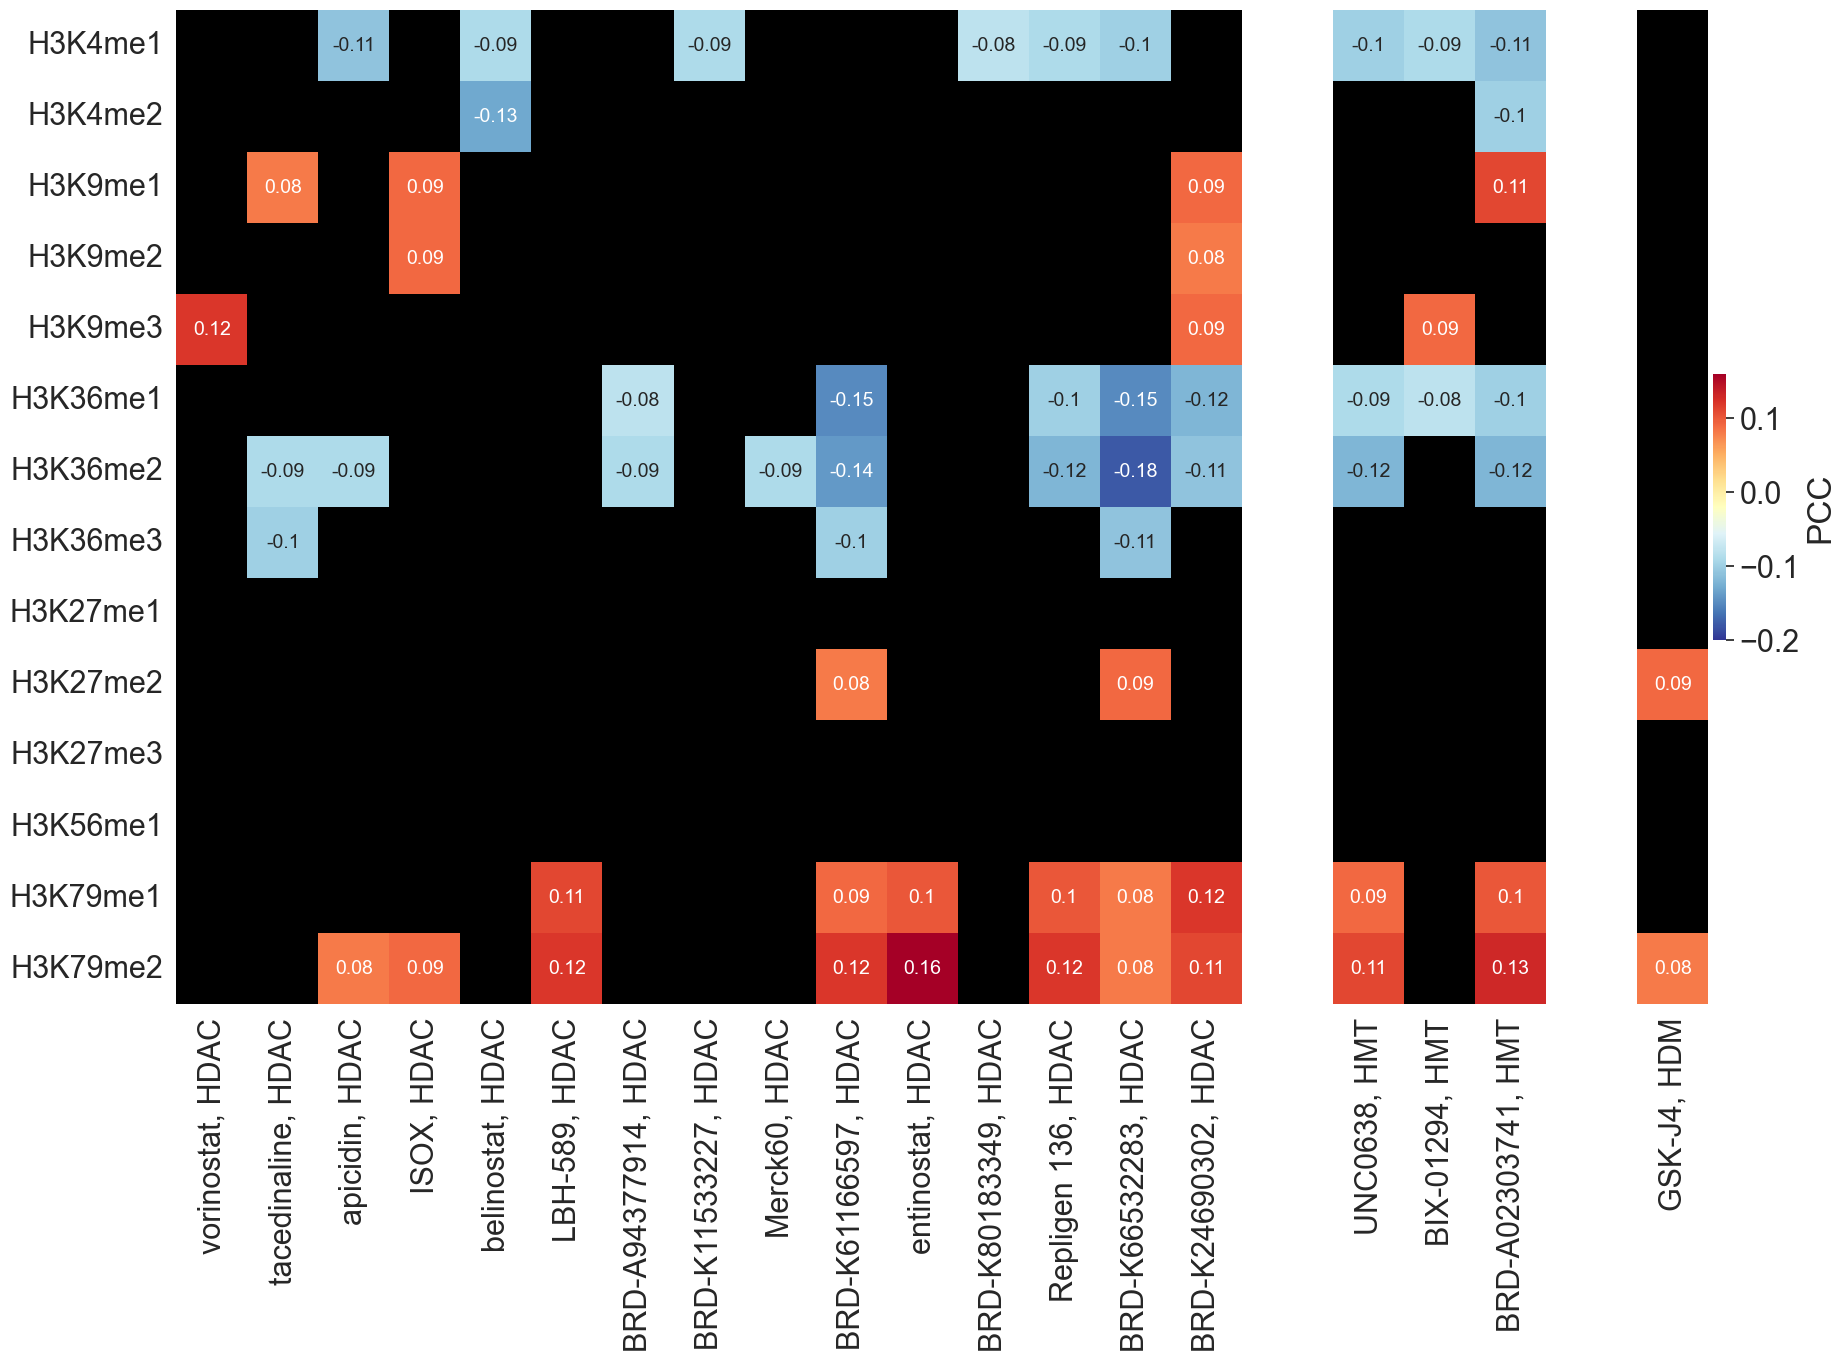

In [70]:
figs, axs = plt.subplots(
    nrows=1,
    ncols=3, 
    figsize=(20, 20), 
    #sharex='col',
    sharey=False,
    gridspec_kw=dict(width_ratios=[3, 0.6, 0.25]),
    dpi=100
)

sns.set(font_scale=2)
plt.rcParams.update({'font.size':14})

d = sns.heatmap(
    hdac_me_df, 
    cmap='RdYlBu_r', 
    mask=hdac_me_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[0],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
e = sns.heatmap(
    hmt_me_df, 
    cmap='RdYlBu_r', 
    mask=hmt_me_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[1],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
e.set(yticklabels=[])

f = sns.heatmap(
    hdm_me_df, 
    cmap='RdYlBu_r', 
    mask=hdm_me_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    vmin=vmin,
    vmax=vmax,
    ax=axs[2],
    cbar_kws={
                "shrink": 0.35,
                "label": "PCC"
    })
f.set(yticklabels=[])
f.set_xticklabels(labels=['GSK-J4, HDM'],  rotation = 90)

axs[0].set_facecolor('black')
axs[1].set_facecolor('black')
axs[2].set_facecolor('black')

#### vii. Number of GCP -> metabolites (non-signalling metabolites)

In [71]:
gcpMetHmNS, gcpMetHmNS_pval, filtered_pcc = generate_heatmap_df(gcpMetPCCAll, gcpMetPvalAll, non_fat_metabolites)
gcpMetHmNS.head(3)

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
2-aminoadipate,NaN,NaN,NaN,NaN,NaN,NaN,0.163008,NaN,NaN,NaN,0.123275,0.120821,0.091013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3-phosphoglycerate,-0.103323,-0.082512,NaN,NaN,-0.086452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108054,NaN,NaN,NaN,NaN,NaN,NaN
alpha-glycerophosphate,NaN,0.102526,0.094165,NaN,NaN,NaN,NaN,0.089998,0.079562,0.105833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
tmp1 = filtered_pcc
tmp2 = gcpMetHmNS_pval

tmp1 = tmp1.reset_index()
tmp1 = tmp1.rename({'index':'Metabolite'}, axis=1)

tmp2 = tmp2.reset_index()
tmp2 = tmp2.rename({'index':'Metabolite'}, axis=1)

tmp1 = pd.melt(frame=tmp1, id_vars='Metabolite', var_name='Histone PTM', value_name='PCC')
tmp2 = pd.melt(frame=tmp2, id_vars='Metabolite', var_name='Histone PTM', value_name='P-Value')
tmp2['FDR'] = fdrcorrection(tmp2['P-Value'], is_sorted=False)[1]

tmp3 = pd.merge(tmp1, tmp2, how='inner', left_on=['Metabolite', 'Histone PTM'], right_on=['Metabolite', 'Histone PTM'])
tmp3.to_csv('D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/tables/MetGcpPCC.csv')

In [73]:
metabolitesGcpMetNS = len(gcp_df.columns) - gcpMetHmNS.isna().sum(axis=1)
metabolitesGcpMetNS = pd.DataFrame(metabolitesGcpMetNS.sort_values(ascending=False), columns=["Number of significant GCP associations"])

metabolitesGcpMetNS = metabolitesGcpMetNS[0:20]
metabolitesGcpMetNS.shape
metabolitesGcpMetNS


,Number of significant GCP associations
pantothenate,9
2-deoxyadenosine,9
AMP,8
2-deoxycytidine,8
1-methylnicotinamide,7
UMP,7
cytidine,7
phosphocreatine,7
GABA,6
GMP,6


C:\Users\Scott\AppData\Local\Temp/ipykernel_25104/3462796102.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[Text(0.0, 0, ''), Text(5.0, 0, ''), Text(10.0, 0, '')]

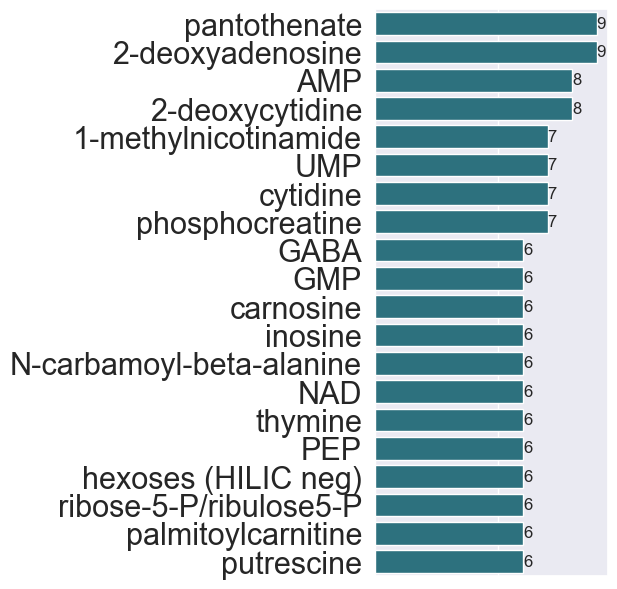

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=metabolitesGcpMetNS, 
                y=metabolitesGcpMetNS.index, 
                x='Number of significant GCP associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])

In [75]:
tmp, mask = prep_clustergram_data(
    gcpMetPCCAll, 
    gcpMetPvalAll, 
    index_filter=metabolitesGcpMetNS.index, 
    num_rows=20
)

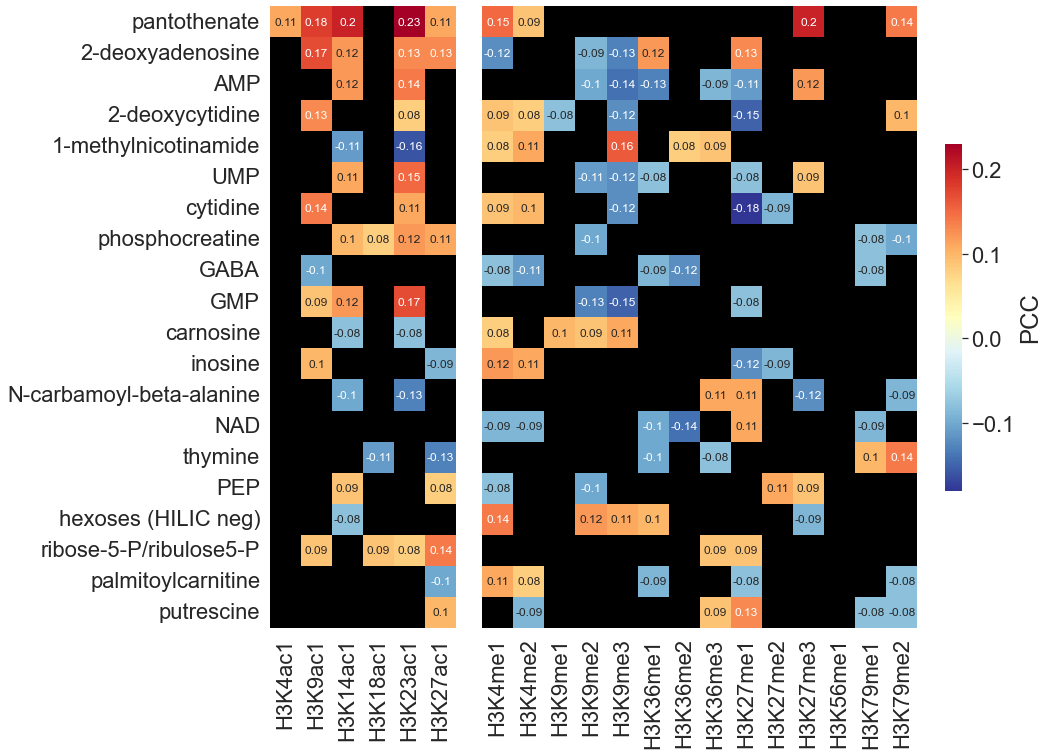

In [76]:
split_into_ptm_groups(tmp, mask)

This code creates heatmaps based on activation/repression PTMs rather than based on acetylation or methylation PTMs.

In [77]:
tmp.head(3)

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
pantothenate,0.147960,0.089160,0.110686,-0.011971,-0.035190,-0.075408,0.179554,0.201979,0.072912,0.232455,0.014406,0.008407,0.010451,-0.061356,0.049926,0.196388,0.105953,0.038574,0.072416,0.138531
2-deoxyadenosine,-0.122951,-0.065083,-0.037636,0.006754,-0.089226,-0.128033,0.165473,0.123140,-0.050870,0.129322,0.119711,0.059992,0.044578,0.127790,0.026407,-0.034389,0.127614,-0.009882,-0.071586,-0.025128
AMP,-0.005380,-0.020264,0.013909,-0.044024,-0.099505,-0.136209,0.051851,0.115565,0.046239,0.139529,-0.133197,-0.072356,-0.089026,-0.108978,0.018146,0.119336,0.003545,-0.023578,-0.018134,-0.021486


In [78]:
annotations = pd.read_excel('C:/Users/Scott/Downloads/Adjacency_mat_PTM_Drug_Metabolite_PCC.xlsx', sheet_name='Sheet1')
annotations = annotations.iloc[:, 0:2]
annotations.head(3)

,Histone_Mark,Histone_PTM
0,Active,H3K27ac1
1,Active,H3K18ac1
2,Active,H3K14ac1


In [90]:
active_annots = annotations.loc[annotations['Histone_Mark'] == 'Active', :]['Histone_PTM'].to_list()
active_hm = tmp.loc[:, active_annots]
active_mask = mask.loc[:, active_annots]

repressive_annots = annotations.loc[annotations['Histone_Mark'] == 'Repressive', :]['Histone_PTM'].to_list()
repressive_hm = tmp.loc[:, repressive_annots]
repressive_mask = mask.loc[:, repressive_annots]


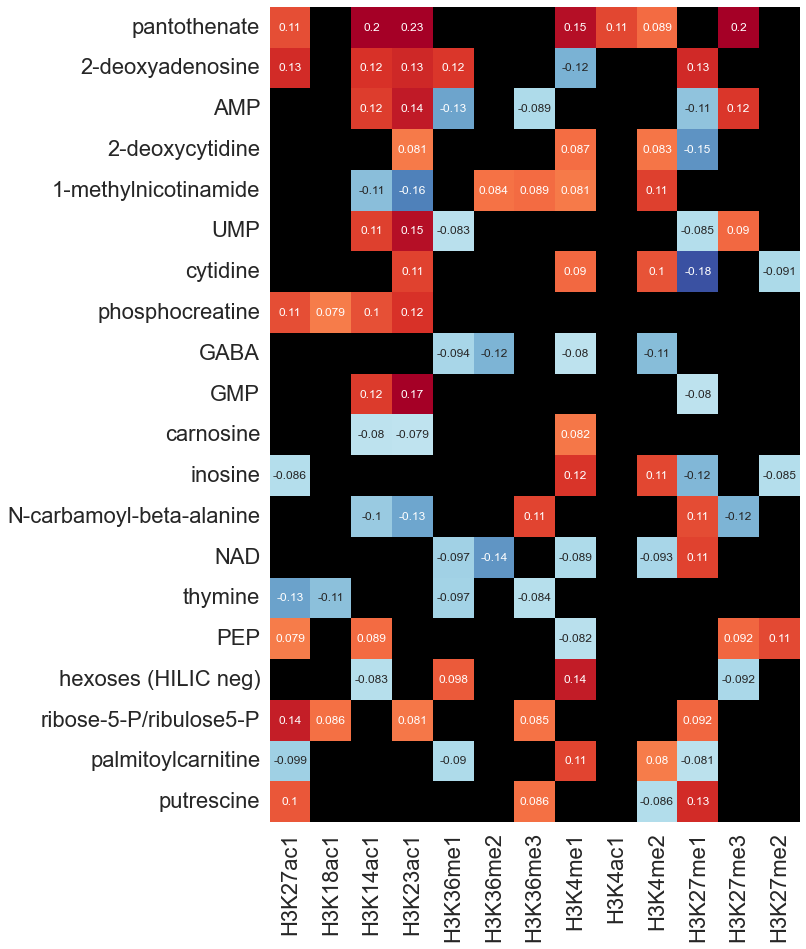

In [100]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
ax1 = sns.heatmap(
    active_hm, 
    cmap='RdYlBu_r', 
    mask=active_mask, 
    square=True,
    annot_kws={"size": 12},
    annot=True,
    vmin=vmin,
    vmax=vmax,
    cbar=False)
ax1.set_facecolor('black')


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, ''),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, ''),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, ''),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '')]

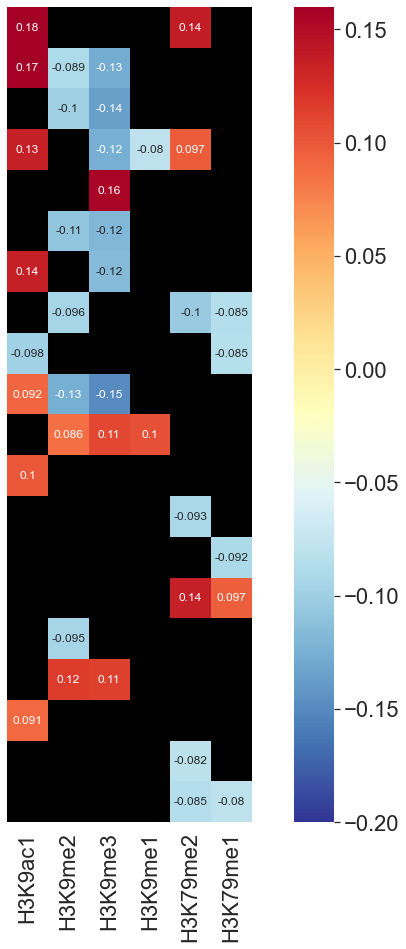

In [101]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
ax2 = sns.heatmap(
    repressive_hm, 
    cmap='RdYlBu_r', 
    mask=repressive_mask, 
    square=True,
    annot_kws={"size": 12},
    annot=True,
    vmin=vmin,
    vmax=vmax,
    cbar=True)
ax2.set_facecolor('black')
ax2.set_yticklabels([])


#### viii. Number of metabolites -> GCPs (non-signalling metabolites)

In [ ]:
histonesGcpMetNS = len(gcpMetHmNS.index) - gcpMetHmNS.isna().sum(axis=0)
histonesGcpMetNS = pd.DataFrame(
    histonesGcpMetNS.sort_values(ascending=False), 
    columns=["Number of significant metabolite associations"]
)

[Text(0.0, 0, ''), Text(25.0, 0, ''), Text(50.0, 0, '')]

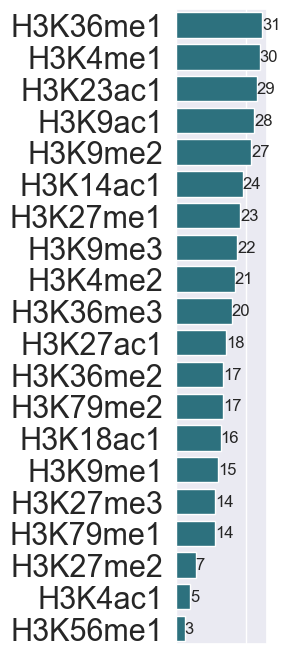

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=histonesGcpMetNS, 
                y=histonesGcpMetNS.index, 
                x='Number of significant metabolite associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])
#plt.title("Histone PTMs associated with significant metabolite correlations", loc='left', fontdict = {'fontsize' : 16})

#### ix. Number of AUCs -> metabolites (non-signalling metabolites)

In [105]:
aucMetHmNS, aucMetHmNS_pval, filtered_pcc = generate_heatmap_df(aucMetPCCAll, aucMetPvalAll, non_fat_metabolites)
aucMetHmNS.head(3)

compound_name,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,BRD-K66532283,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
2-aminoadipate,NaN,NaN,NaN,0.097305,NaN,NaN,NaN,NaN,0.081414,NaN,...,0.087101,NaN,NaN,NaN,NaN,NaN,NaN,0.086596,NaN,NaN
3-phosphoglycerate,NaN,0.127765,NaN,0.133958,NaN,0.143864,NaN,NaN,NaN,0.094807,...,0.102433,NaN,0.082738,NaN,0.092067,NaN,NaN,0.171105,NaN,NaN
alpha-glycerophosphate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
filtered_pcc.reset_index()

compound_name,index,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
0,2-aminoadipate,0.077102,0.017971,-0.075858,0.097305,-0.053701,0.009472,0.024238,-0.041733,0.081414,...,0.087101,0.043318,0.069573,-0.076733,-0.015870,0.032201,0.015986,0.086596,0.049452,0.071538
1,3-phosphoglycerate,-0.013320,0.127765,-0.051975,0.133958,0.074297,0.143864,0.057628,0.048927,0.066821,...,0.102433,0.077197,0.082738,-0.070676,0.092067,0.050599,-0.008644,0.171105,0.066365,0.037230
2,alpha-glycerophosphate,0.001631,0.071634,-0.075684,-0.073237,-0.035908,-0.024127,-0.015597,-0.039307,-0.070131,...,-0.043932,-0.066534,-0.059629,-0.056204,-0.031568,-0.053778,0.028999,-0.017364,-0.009219,-0.075688
3,4-pyridoxate,-0.015660,-0.012407,0.093849,0.010526,0.009226,-0.000019,-0.029560,0.024945,0.009787,...,-0.003495,0.044265,0.015299,0.036816,-0.041519,-0.005567,0.056095,-0.078140,0.033665,-0.018532
4,aconitate,0.021304,0.185469,-0.044084,0.135541,0.004713,0.079108,0.064356,0.036749,0.064266,...,0.107147,0.096321,0.058167,-0.020415,0.116920,0.071812,-0.038334,0.137453,0.051536,0.077401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,oleylcarnitine,-0.028840,0.013490,0.087289,-0.062173,0.010902,-0.048187,-0.028222,-0.008587,0.029186,...,-0.032370,0.004056,0.004141,0.093036,-0.007996,-0.038875,-0.007706,-0.018494,-0.049216,0.030905
132,arachidonyl_carnitine,-0.064756,-0.132472,0.122217,-0.112580,-0.005044,-0.090797,-0.053111,-0.017008,-0.073942,...,-0.118226,-0.141364,-0.129943,-0.001057,-0.095553,-0.037605,-0.010670,-0.129508,-0.053961,-0.116086
133,sarcosine,-0.017775,0.089829,-0.053715,0.134346,0.058877,-0.000181,0.110575,-0.018233,0.127454,...,0.117294,0.049920,0.065549,-0.007833,0.021406,0.027118,-0.066308,0.045669,0.073444,0.054230
134,beta-alanine,0.062674,0.162572,-0.028592,0.121362,-0.009900,0.032004,0.019029,-0.015315,0.062873,...,0.098483,0.062586,0.035820,-0.064692,0.124252,-0.026880,-0.035543,0.104953,0.033403,0.029530


In [107]:
aucMetHmNS_pval.reset_index()

compound_name,index,AGK-2,BIX-01294,BRD-A02303741,BRD-A94377914,BRD-K11533227,BRD-K24690302,BRD-K29313308,BRD-K51490254,BRD-K61166597,...,apicidin,belinostat,entinostat,isonicotinohydroxamic acid,methylstat,pandacostat,salermide,tacedinaline,tubastatin A,vorinostat
0,2-aminoadipate,0.054616,0.654644,0.058651,0.015196,0.181040,0.813627,0.546261,0.298719,0.042384,...,0.029851,0.280729,0.082961,0.055788,0.692820,0.422733,0.690694,0.030818,0.218099,0.074613
1,3-phosphoglycerate,0.740240,0.001407,0.195489,0.000810,0.064057,0.000319,0.151135,0.223028,0.095906,...,0.010581,0.054318,0.039126,0.078184,0.021652,0.207600,0.829641,0.000018,0.098204,0.353947
2,alpha-glycerophosphate,0.967620,0.074223,0.059232,0.067954,0.371303,0.548109,0.697846,0.327715,0.080519,...,0.273966,0.097347,0.137416,0.161507,0.431911,0.180413,0.470331,0.665590,0.818508,0.059218
3,4-pyridoxate,0.696691,0.757465,0.019229,0.793328,0.818368,0.999626,0.461791,0.534618,0.807542,...,0.930686,0.270342,0.703346,0.359320,0.301204,0.889796,0.162328,0.051430,0.401941,0.644586
4,aconitate,0.595899,0.000003,0.272303,0.000701,0.906622,0.048602,0.108830,0.360201,0.109328,...,0.007483,0.016262,0.147341,0.611334,0.003499,0.073503,0.339843,0.000587,0.199289,0.053681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,oleylcarnitine,0.472778,0.737039,0.029498,0.121390,0.786119,0.230119,0.482314,0.830759,0.467476,...,0.420312,0.919583,0.917908,0.020304,0.842245,0.333073,0.847897,0.645267,0.220304,0.441659
132,arachidonyl_carnitine,0.106645,0.000927,0.002263,0.004938,0.900102,0.023537,0.185885,0.672029,0.065342,...,0.003147,0.000406,0.001162,0.979016,0.017137,0.349109,0.790558,0.001208,0.178933,0.003742
133,sarcosine,0.658170,0.025067,0.180921,0.000782,0.142458,0.996403,0.005768,0.649936,0.001446,...,0.003395,0.213765,0.102415,0.845413,0.594132,0.499621,0.098490,0.255424,0.067177,0.176769
134,beta-alanine,0.118409,0.000046,0.476594,0.002430,0.805365,0.425577,0.635737,0.703041,0.117242,...,0.014003,0.118928,0.372483,0.106994,0.001905,0.503399,0.376187,0.008806,0.405620,0.462248


In [108]:
tmp1 = filtered_pcc
tmp2 = aucMetHmNS_pval

tmp1 = tmp1.reset_index()
tmp2 = tmp2.reset_index()
tmp1 = tmp1.rename({'index':'Metabolite'}, axis=1)
tmp2 = tmp2.rename({'index':'Metabolite'}, axis=1)

tmp1 = pd.melt(frame=tmp1, id_vars='Metabolite', var_name='Drug', value_name='PCC')
tmp2 = pd.melt(frame=tmp2, id_vars='Metabolite', var_name='Drug', value_name='P-Value')
tmp2['FDR'] = fdrcorrection(tmp2['P-Value'], is_sorted=False)[1]

tmp3 = pd.merge(tmp1, tmp2, how='inner', left_on=['Drug', 'Metabolite'], right_on=['Drug', 'Metabolite'])
tmp3.to_csv('D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/tables/MetAucPCC.csv')

In [109]:
metaboliteImportanceNS = len(auc_table.columns) - aucMetHmNS.isna().sum(axis=1)
metaboliteImportanceNS = pd.DataFrame(
    metaboliteImportanceNS.sort_values(ascending=False), 
    columns=["Number of significant drug associations"]
)
metaboliteImportanceNS = metaboliteImportanceNS[0:20]
metaboliteImportanceNS.shape

(20, 1)

In [110]:
metaboliteImportanceNS

,Number of significant drug associations
1-methylnicotinamide,21
xanthosine,21
NADP,20
sorbitol,20
lactate,19
choline,18
glutathione oxidized,18
AMP,17
oxalate,17
N-carbamoyl-beta-alanine,17


C:\Users\Scott\AppData\Local\Temp/ipykernel_25104/505667128.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[Text(0.0, 0, ''), Text(10.0, 0, ''), Text(20.0, 0, ''), Text(30.0, 0, '')]

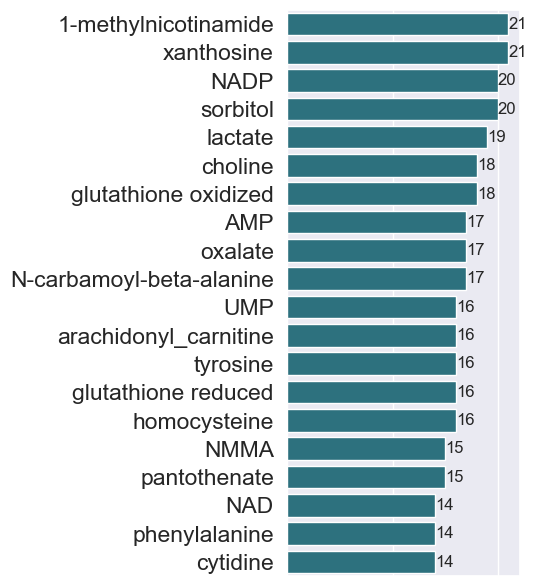

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
ax = sns.barplot(data=metaboliteImportanceNS, 
                y=metaboliteImportanceNS.index, 
                x='Number of significant drug associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])

#### x. Number of metabolites -> AUCs (non-signalling metabolites)

In [112]:
drugImportanceNS = len(aucMetHmNS.index) - aucMetHmNS.isna().sum(axis=0)
drugImportanceNS = pd.DataFrame(drugImportanceNS.sort_values(ascending=False), 
    columns=["Number of significant metabolite associations"]
)
drugImportanceNS = drugImportanceNS[0:20]

In [113]:
drugImportanceNS = pd.merge(
    drugImportanceNS, tmp_uniq_cmpds, 
    how='inner', 
    left_index=True, right_on='compound_name'
)
drugImportanceNS["Name, Type"] = drugImportanceNS["compound_name"].astype(str).str.cat(drugImportanceNS["Type"].astype(str), sep=", ")
drugImportanceNS

,Number of significant metabolite associations,compound_name,target_or_activity_of_compound,Type,"Name, Type"
2,78,BIX-01294,inhibitor of G9a histone methyltransferase,HMT,"BIX-01294, HMT"
21,72,Repligen 136,inhibitor of HDAC3,HDAC,"Repligen 136, HDAC"
12,65,BRD-A94377914,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"BRD-A94377914, HDAC"
1,55,UNC0638,inhibitor of EHMT2 and GLP methyltransferase,HMT,"UNC0638, HMT"
18,52,tacedinaline,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"tacedinaline, HDAC"
16,51,entinostat,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"entinostat, HDAC"
15,49,belinostat,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"belinostat, HDAC"
27,46,methylstat,inhibitor of lysine specific demethylases,HDM,"methylstat, HDM"
14,45,apicidin,"inhibitor of HDAC1, HDAC2, HDAC3, HDAC6, and H...",HDAC,"apicidin, HDAC"
29,42,GSK-J4,inhibitor of lysine-specific demethylases,HDM,"GSK-J4, HDM"


C:\Users\Scott\AppData\Local\Temp/ipykernel_25104/1059297262.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Text(-231.75, 0.5, '')

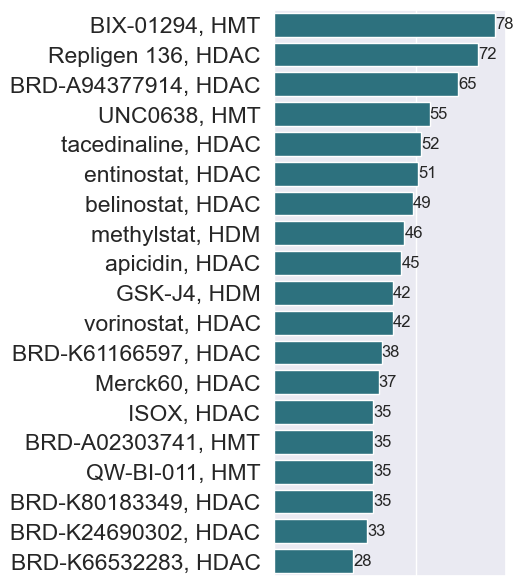

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(3, 7.5), dpi=100,
                       )
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
plt.rcParams.update({'font.size':12})
drugImportanceNS = drugImportanceNS.drop([0], axis=0)
ax = sns.barplot(data=drugImportanceNS, 
                y='Name, Type', 
                x='Number of significant metabolite associations',
                color="#1F7A8C")
ax.bar_label(ax.containers[0])
plt.tight_layout()
ax.set(xlabel=None)
ax.set_xticklabels([])
plt.ylabel('')

In [115]:
aucMetPCCSubsetNS = aucMetPCCAll.loc[aucMetPCCAll.index.str.contains('|'.join(drugImportanceNS["Name, Type"].str.split(',').str[0])), :]
aucMetPvalSubsetNS = aucMetPvalAll.loc[aucMetPvalAll.index.str.contains('|'.join(drugImportanceNS["Name, Type"].str.split(',').str[0])), 
:]
drugImportanceSubsetNS = drugImportanceNS.loc[drugImportanceNS['compound_name'].isin(aucMetPvalSubsetNS.index), :]

In [116]:
tmp, mask = prep_clustergram_data(aucMetPCCSubsetNS, \
                                    aucMetPvalSubsetNS, \
                                    index_filter = metaboliteImportanceNS.index, \
                                    col_filter = drugImportanceSubsetNS['compound_name'], 
                                    num_rows=20, \
                                    num_cols=20,
                                    alpha=0.01)
tmp.columns = drugImportanceNS["Name, Type"]
mask.columns = drugImportanceNS["Name, Type"]

print(tmp.shape)
tmp

(20, 19)


"Name, Type","BIX-01294, HMT","Repligen 136, HDAC","BRD-A94377914, HDAC","UNC0638, HMT","tacedinaline, HDAC","entinostat, HDAC","belinostat, HDAC","methylstat, HDM","apicidin, HDAC","GSK-J4, HDM","vorinostat, HDAC","BRD-K61166597, HDAC","Merck60, HDAC","ISOX, HDAC","BRD-A02303741, HMT","QW-BI-011, HMT","BRD-K80183349, HDAC","BRD-K24690302, HDAC","BRD-K66532283, HDAC"
1-methylnicotinamide,0.114096,0.061650,0.189060,0.048447,0.114207,0.120929,0.177404,0.172369,0.131795,0.106216,0.049507,0.174658,0.032310,0.141014,0.218177,0.150978,0.046851,0.168622,0.207541
xanthosine,0.085676,0.087380,0.159939,-0.026868,0.086780,0.033067,0.041125,0.109856,0.091089,0.130962,0.151437,0.125250,0.088375,0.134520,0.114870,0.102647,0.121895,0.100930,0.157830
NADP,0.152966,0.001626,0.137786,0.054554,0.132201,0.091758,0.074896,0.154505,0.101228,0.118887,0.090303,0.082768,0.144732,0.129081,0.087126,0.108185,0.220388,0.137515,0.085597
sorbitol,0.151276,0.107308,0.176264,0.043549,0.173410,0.119099,0.085321,0.203353,0.125561,0.140941,0.129782,0.180493,0.095224,0.153100,0.155954,0.148363,0.108229,0.138487,0.163936
lactate,0.127473,-0.030114,0.167952,0.079520,0.057329,0.065365,0.124016,0.128491,0.111356,0.037051,0.035208,0.079783,0.081811,0.117157,0.128500,0.103934,0.084206,0.111204,0.089248
choline,-0.130458,0.116438,-0.146855,-0.116701,-0.103497,-0.184799,-0.152811,-0.055114,-0.120274,-0.077417,0.000164,-0.021103,-0.126694,-0.129495,-0.117268,-0.101670,-0.105248,-0.104490,-0.067161
glutathione oxidized,0.104712,-0.039641,0.129024,0.012460,0.100896,0.057899,0.100319,0.119531,0.117662,0.102350,0.085845,0.087471,0.055273,0.116628,0.095338,0.108319,0.183149,0.108338,0.085527
AMP,-0.117884,-0.092231,-0.163158,-0.065289,-0.132711,-0.076583,-0.090017,-0.134725,-0.071962,-0.154361,-0.155561,-0.221338,-0.056579,-0.080442,-0.141827,-0.142229,-0.093769,-0.092705,-0.166188
oxalate,-0.163411,0.087618,-0.158960,-0.049228,-0.085440,-0.108134,-0.100336,-0.114715,-0.100473,-0.056629,-0.052180,-0.171702,-0.052721,-0.128140,-0.142743,-0.125543,-0.141460,-0.172903,-0.117081
N-carbamoyl-beta-alanine,0.159439,-0.042754,0.148733,0.121712,0.074186,0.101289,0.106628,0.124877,0.087216,0.068496,0.013807,0.121286,0.075255,0.088979,0.156521,0.176891,0.107343,0.126734,0.138176


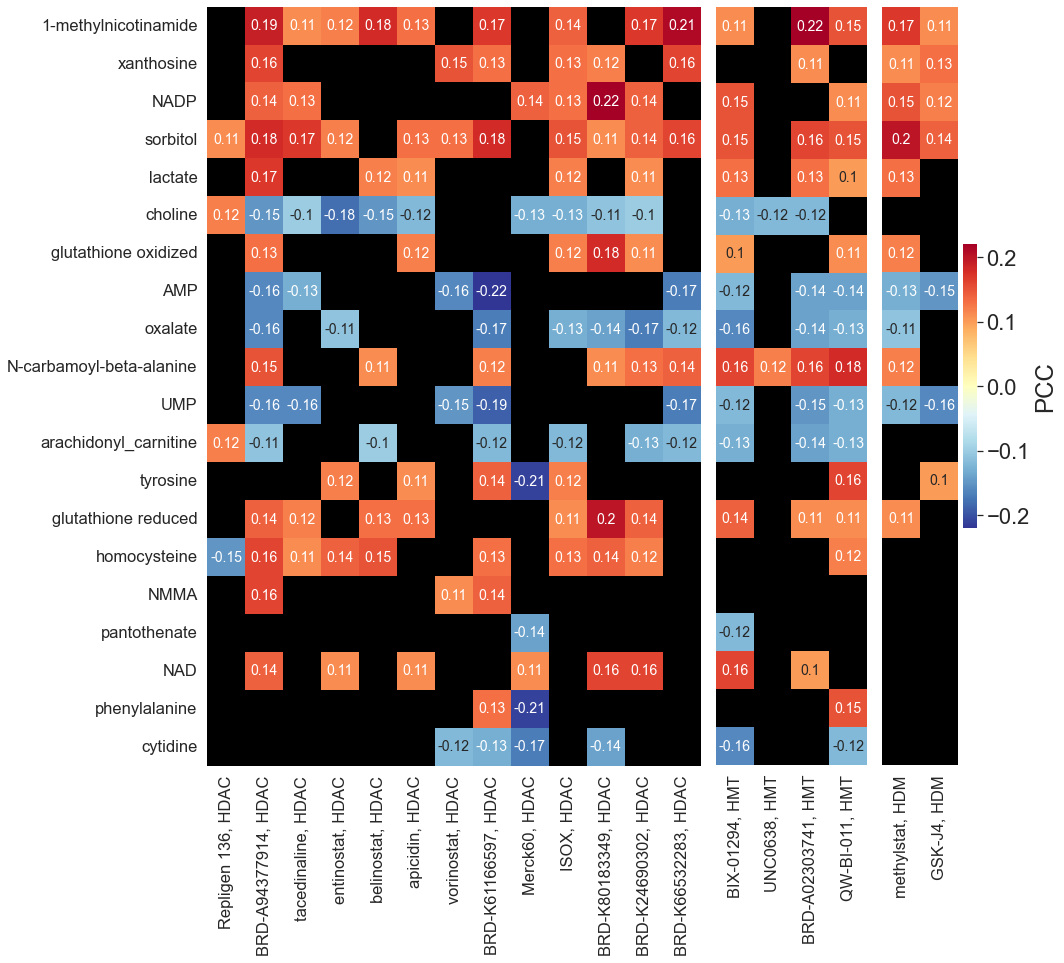

In [117]:
tmp = tmp.round(2)

hdac_df = tmp[[x for x in tmp.columns if 'HDAC' in x]]
hmt_df = tmp[[x for x in tmp.columns if 'HMT' in x]]
hdm_df = tmp[[x for x in tmp.columns if 'HDM' in x]]

hdac_df.columns.name = ''
hmt_df.columns.name = ''
hdm_df.columns.name = ''

hdac_mask = mask[[x for x in mask.columns if 'HDAC' in x]]
hmt_mask = mask[[x for x in mask.columns if 'HMT' in x]]
hdm_mask = mask[[x for x in mask.columns if 'HDM' in x]]

vmin = min([hdac_df.values.min(), hmt_df.values.min(), hdm_df.values.min()])
vmax = max([hdac_df.values.max(), hmt_df.values.max(), hdm_df.values.max()])
figs, axs = plt.subplots(
    ncols=3, 
    sharey=True, 
    figsize=(15, 15), 
    gridspec_kw=dict(width_ratios=[2, 0.614, 0.384], height_ratios=[1])
)

sns.set(font_scale=2)
plt.rcParams.update({'font.size':14})

sns.heatmap(
    hdac_df, 
    cmap='RdYlBu_r', 
    mask=hdac_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[0],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
sns.heatmap(
    hmt_df, 
    cmap='RdYlBu_r', 
    mask=hmt_mask, 
    annot_kws={"size": 14},
    annot=True,
    square=True,
    ax=axs[1],
    vmin=vmin,
    vmax=vmax,
    cbar=False)
sns.heatmap(
    hdm_df, 
    cmap='RdYlBu_r', 
    mask=hdm_mask, 
    annot_kws={
        "size": 14,
    },
    annot=True,
    square=True,
    vmin=vmin,
    vmax=vmax,
    ax=axs[2],
    cbar_kws={
                "shrink": 0.35,
                "label": "PCC"
    })
axs[0].set_facecolor('black')
axs[1].set_facecolor('black')
axs[2].set_facecolor('black')

plt.tight_layout()

## 7. Save Data

In [ ]:
tmp = met_df.copy()
tmp = tmp[non_fat_metabolites]

In [ ]:
path = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/processed/model_inputs.xlsx"
writer = pd.ExcelWriter(path)

gcp_df.to_excel(writer, sheet_name = 'GCP_all', index = True)
met_df.to_excel(writer, sheet_name = 'MET_all', index = True)
tmp.to_excel(writer, sheet_name = 'MET_nonsignaling', index = True)
auc_table.to_excel(writer, sheet_name = 'AUC_all', index = True)

writer.save()